## Loading Libraries

In [1]:
#Packages related to general operating system & warnings
import os 
import warnings
warnings.filterwarnings('ignore')

import pickle

#Packages related to data importing, manipulation, exploratory data analysis, data understanding
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling
import scipy.stats as stats

#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport

#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

#Modules related to split the data & gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV

#Module related to calculation of metrics
from sklearn import metrics

#Module related to VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Moudles related to feature selection
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2, SelectPercentile, f_classif, mutual_info_classif, f_regression, VarianceThreshold, SelectFromModel, mutual_info_classif, mutual_info_regression, SelectFpr, SelectFdr, SelectFwe


#Modules related key techniques of supervised learning 
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor#, export_graphviz, export
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor 
from xgboost import  XGBRegressor
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVR,SVR
#from sklearn.neural_network import MLPClassifier, MLPRegressor

#import dtale
pd.set_option('display.max_columns',50)

<Figure size 432x216 with 0 Axes>

# DataPreparation

In [2]:
cd '/kaggle/input/credit-card'

/kaggle/input/credit-card


In [3]:
CredCD = pd.read_excel('CreditConsumptionData.xlsx',index_col='ID')
CustB =  pd.read_excel('CustomerBehaviorData.xlsx',index_col='ID')
CustD = pd.read_excel('CustomerDemographics.xlsx',index_col='ID')

In [4]:
CredCD.shape

(20000, 1)

In [5]:
CustB.shape

(20000, 38)

In [6]:
CustD.shape

(20000, 9)

In [7]:
C1    = pd.merge(left=CustB,right=CustD,how='outer', on='ID')
final = pd.merge(left=C1,right = CredCD,how='outer', on = 'ID')

In [8]:
#Splitting train and unknown data

data = final[-final.cc_cons.isna()]
real = final[final.cc_cons.isna()] 

# EDA


In [9]:
data.shape

(15000, 48)

In [10]:
real.shape

(5000, 48)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 17051 to 4547
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cc_cons_apr                   15000 non-null  float64
 1   dc_cons_apr                   15000 non-null  float64
 2   cc_cons_may                   15000 non-null  float64
 3   dc_cons_may                   15000 non-null  float64
 4   cc_cons_jun                   15000 non-null  float64
 5   dc_cons_jun                   15000 non-null  float64
 6   cc_count_apr                  14999 non-null  float64
 7   cc_count_may                  15000 non-null  int64  
 8   cc_count_jun                  15000 non-null  int64  
 9   dc_count_apr                  15000 non-null  int64  
 10  dc_count_may                  15000 non-null  int64  
 11  dc_count_jun                  15000 non-null  int64  
 12  card_lim                      15000 non-null  int64  
 13

In [12]:
#Changing column names to all small letters
data.columns = data.columns.str.lower()

In [13]:
#AutoEDA using pandas profiling
#report = ProfileReport(df = train)
#report.to_file('profile_train.pdf')

In [14]:
#Data Audit

# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])



In [15]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [16]:
# A utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [17]:
#Function to get summary about outliers
def outlier_summary(data):
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)
    iqr = upper_quartile - lower_quartile
    upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
    lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
    outliers_count = data[data>upper_whisker].count()+data[data<lower_whisker].count()
    out = pd.Series(data = [median,upper_quartile,lower_quartile,iqr,upper_whisker,lower_whisker,outliers_count],index = ['median','upper_quartile','lower_quartile','iqr','upper_whisker','lower_whisker','outliers_count'])
    return out

In [18]:
#removing region_code as a variable since it is a nominal variable but as int data type

data=data.drop(columns='region_code')

In [19]:
col=data.columns
len(col)

47

In [20]:
data.head()

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,account_type,gender,age,income,emp_tenure_years,tenure_with_bank,netbanking_flag,avg_days_between_transaction,cc_cons
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.0,19.0,10,2,53,1,42,358000,1,1,1.0,1,331.2,130000.00,300500.0,12174.0,25210.23,27532.37,103.0,36,28579.0,44974.63,42852.00,1,108,97916.0,45253.64,47635.00,2,18,19947.0,Y,3448.84,current,M,30,MEDIUM,7.0,5,1,20.0,13434.0
11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.0,4.0,60,1,4,1,17,114000,1,1,1.0,1,5809950.0,3.00,610000.0,2351.0,30937.00,50784.00,40.0,35,25379.0,117575.67,24257.00,1,4,25125.0,12912.33,18369.00,3,49,20585.0,Y,3812.69,current,M,37,LOW,10.2,8,1,5.0,449.0
7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.0,2.0,83,47,4,62,42,360000,1,1,1.0,1,27324.0,176487.60,2156.0,3735.0,12940.25,26345.00,11.0,3,19224.0,14646.35,38306.00,70,11,38546.0,93567.51,26713.00,47,49,13950.0,Y,9432.90,current,M,33,MEDIUM,3.9,3,1,15.0,11968.0
14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.0,12.0,2,16,24,12,58,155000,1,1,1.0,1,370776.0,63000.00,26241.0,0.0,78122.15,49660.00,42.0,26,72186.0,14719.00,46132.05,43,1,180315.0,176394.48,35062.74,3,37,37018.0,Y,144.61,current,M,63,LOW,25.8,6,0,15.0,32029.0
8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.0,15.0,13,61,7,5,80,362000,1,1,1.0,1,10006.2,7216.53,13873.0,-4679.0,6855.71,933699.00,46.0,35,18867.0,189938.76,37191.00,2,14,13480.0,3167.00,19056.00,2,15,24274.0,Y,1887.89,saving,M,33,MEDIUM,6.5,7,0,9.0,16394.0


In [21]:

catcol = ['loan_enq','account_type','gender','income','netbanking_flag',]
numcol = list(data.columns.difference(catcol))
numcol

['age',
 'avg_days_between_transaction',
 'card_lim',
 'cc_cons',
 'cc_cons_apr',
 'cc_cons_jun',
 'cc_cons_may',
 'cc_count_apr',
 'cc_count_jun',
 'cc_count_may',
 'credit_amount_apr',
 'credit_amount_jun',
 'credit_amount_may',
 'credit_count_apr',
 'credit_count_jun',
 'credit_count_may',
 'dc_cons_apr',
 'dc_cons_jun',
 'dc_cons_may',
 'dc_count_apr',
 'dc_count_jun',
 'dc_count_may',
 'debit_amount_apr',
 'debit_amount_jun',
 'debit_amount_may',
 'debit_count_apr',
 'debit_count_jun',
 'debit_count_may',
 'emi_active',
 'emp_tenure_years',
 'investment_1',
 'investment_2',
 'investment_3',
 'investment_4',
 'max_credit_amount_apr',
 'max_credit_amount_jun',
 'max_credit_amount_may',
 'personal_loan_active',
 'personal_loan_closed',
 'tenure_with_bank',
 'vehicle_loan_active',
 'vehicle_loan_closed']

In [22]:
#Data Audit for numerical variables
data[numcol].apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,15000.0,0.0,7.168590e+05,47.790600,40.00,3.063277e+01,9.383664e+02,25.00,27.0000,28.00000,29.000,33.0000,40.00,53.0000,64.000,6.600000e+01,2.220000e+02,223.00
avg_days_between_transaction,14999.0,1.0,1.657330e+05,11.049603,11.00,5.492379e+00,3.016623e+01,2.00,2.0000,2.00000,3.000,6.0000,11.00,16.0000,19.000,2.000000e+01,2.000000e+01,20.00
card_lim,15000.0,0.0,4.155077e+09,277005.147400,272000.00,1.794295e+05,3.219496e+10,0.00,16000.0000,27000.00000,47000.000,124000.0000,272000.00,400000.0000,522000.000,5.750000e+05,7.500000e+05,1000000.00
cc_cons,15000.0,0.0,8.273659e+08,55157.729867,13364.00,9.767097e+04,9.539619e+09,0.00,271.9900,1290.85000,2633.600,6768.0000,13364.00,20105.7500,219688.700,3.098520e+05,3.952905e+05,408382.00
cc_cons_apr,15000.0,0.0,2.693609e+08,17957.391719,10288.10,2.518794e+04,6.344323e+08,253.00,658.7669,1239.40000,1918.970,4411.0275,10288.10,21405.0000,40998.681,6.015714e+04,1.238253e+05,441031.33
cc_cons_jun,15000.0,0.0,1.819352e+08,12129.010832,6655.25,1.848878e+04,3.418350e+08,65.00,334.0000,833.00000,1377.200,3004.5000,6655.25,14247.0000,27043.490,4.012357e+04,8.696523e+04,382914.10
cc_cons_may,15000.0,0.0,2.450558e+08,16337.054662,8695.03,2.706085e+04,7.322896e+08,157.00,508.9800,1043.04000,1677.000,3638.0000,8695.03,18951.3000,36299.360,5.488771e+04,1.264680e+05,1117246.31
cc_count_apr,14999.0,1.0,6.223010e+05,41.489499,10.00,9.743539e+01,9.493656e+03,1.00,1.0000,1.00000,2.000,5.0000,10.00,44.0000,80.000,1.240000e+02,5.310000e+02,531.00
cc_count_jun,15000.0,0.0,6.226050e+05,41.507000,35.00,4.734292e+01,2.241352e+03,1.00,1.0000,3.00000,4.000,10.0000,35.00,61.0000,85.000,8.900000e+01,1.350000e+02,653.00
cc_count_may,15000.0,0.0,5.023530e+05,33.490200,23.00,4.954100e+01,2.454311e+03,1.00,1.0000,2.00000,3.000,8.0000,23.00,43.0000,83.000,9.300000e+01,1.280000e+02,601.00


In [23]:
data[catcol].apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
loan_enq,14998,2,Y,14998,100.0
account_type,15000,0,current,12727,84.85
gender,15000,0,M,12945,86.3
income,15000,0,MEDIUM,9612,64.08
netbanking_flag,15000.0,0.0,1.0,10793.0,71.95


In [24]:

#Detetcing missing values in the data

data.isna().sum().sum()

9

In [25]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.median())
    elif(x.dtypes == 'object'):
        x = x.fillna(x.mode()[0])
    return x

In [26]:
#Missing value imputation 
data = data.apply(missing_imputation)

In [27]:
data.isna().sum().sum()

0

In [28]:
data.income.unique()

array(['MEDIUM', 'LOW', 'HIGH'], dtype=object)

In [29]:
#Label ecncoding income variable
data['income'] = np.where(data.income=='LOW',1,np.where(data.income=='MEDIUM',2,3))

In [30]:
data[catcol].head()

,loan_enq,account_type,gender,income,netbanking_flag
ID,,,,,
17051,Y,current,M,2,1
11491,Y,current,M,1,1
7433,Y,current,M,2,1
14606,Y,current,M,1,0
8381,Y,saving,M,2,0


In [31]:
dummy = list(data.select_dtypes([object]).columns)
dummy

['loan_enq', 'account_type', 'gender']

In [32]:
#One-hot encoding binomial variables

data = create_dummies(data,dummy)

In [33]:
data.head()

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,income,emp_tenure_years,tenure_with_bank,netbanking_flag,avg_days_between_transaction,cc_cons,account_type_saving,gender_M
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.0,19.0,10,2,53,1,42,358000,1,1,1.0,1,331.2,130000.00,300500.0,12174.0,25210.23,27532.37,103.0,36,28579.0,44974.63,42852.00,1,108,97916.0,45253.64,47635.00,2,18,19947.0,3448.84,30,2,7.0,5,1,20.0,13434.0,0,1
11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.0,4.0,60,1,4,1,17,114000,1,1,1.0,1,5809950.0,3.00,610000.0,2351.0,30937.00,50784.00,40.0,35,25379.0,117575.67,24257.00,1,4,25125.0,12912.33,18369.00,3,49,20585.0,3812.69,37,1,10.2,8,1,5.0,449.0,0,1
7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.0,2.0,83,47,4,62,42,360000,1,1,1.0,1,27324.0,176487.60,2156.0,3735.0,12940.25,26345.00,11.0,3,19224.0,14646.35,38306.00,70,11,38546.0,93567.51,26713.00,47,49,13950.0,9432.90,33,2,3.9,3,1,15.0,11968.0,0,1
14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.0,12.0,2,16,24,12,58,155000,1,1,1.0,1,370776.0,63000.00,26241.0,0.0,78122.15,49660.00,42.0,26,72186.0,14719.00,46132.05,43,1,180315.0,176394.48,35062.74,3,37,37018.0,144.61,63,1,25.8,6,0,15.0,32029.0,0,1
8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.0,15.0,13,61,7,5,80,362000,1,1,1.0,1,10006.2,7216.53,13873.0,-4679.0,6855.71,933699.00,46.0,35,18867.0,189938.76,37191.00,2,14,13480.0,3167.00,19056.00,2,15,24274.0,1887.89,33,2,6.5,7,0,9.0,16394.0,1,1


In [34]:
#checking for coefficient  of variance

cv = pd.Series(data.mean()/data.std())
cv.sort_values(ascending=False)

vehicle_loan_closed                  inf
personal_loan_closed                 inf
vehicle_loan_active                  inf
personal_loan_active                 inf
income                          3.185682
gender_M                        2.509751
avg_days_between_transaction    2.011873
tenure_with_bank                1.922685
netbanking_flag                 1.601660
age                             1.560114
card_lim                        1.543810
debit_count_jun                 1.272415
debit_count_apr                 1.185728
dc_count_jun                    1.035374
debit_count_may                 1.011336
credit_count_apr                0.891137
dc_count_apr                    0.886947
cc_count_jun                    0.876731
dc_count_may                    0.818141
emp_tenure_years                0.747515
credit_count_jun                0.733319
cc_cons_apr                     0.712936
credit_count_may                0.707875
cc_count_may                    0.676010
cc_cons_jun     

In [35]:
#Dropping constant columns
l=[]
for i in data.columns:
    if len(data[i].unique())<2:
        l.append(i)
        print(i,data[i].unique())
print(l)

data.drop(l,axis=1,inplace=True)

personal_loan_active [1]
vehicle_loan_active [1]
personal_loan_closed [1.]
vehicle_loan_closed [1]
['personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed']


In [36]:
numcol = list(set(numcol)-set(l))

In [37]:
#Checking for outliers in the numerical columns
data[numcol].apply(outlier_summary).T['outliers_count']

credit_amount_jun               1218.0
credit_count_may                2655.0
dc_cons_apr                     1220.0
dc_count_jun                       0.0
debit_amount_may                1235.0
dc_count_apr                     434.0
cc_cons_jun                     1181.0
investment_4                    1004.0
credit_amount_apr               1229.0
emp_tenure_years                 919.0
dc_cons_jun                     1366.0
investment_2                    1297.0
debit_count_apr                  231.0
avg_days_between_transaction       0.0
card_lim                          59.0
max_credit_amount_jun           1385.0
investment_3                    1554.0
dc_cons_may                     1248.0
cc_count_may                     709.0
cc_cons_may                     1202.0
credit_count_jun                2217.0
age                              534.0
max_credit_amount_apr           1376.0
cc_count_apr                     883.0
tenure_with_bank                   0.0
cc_cons                  

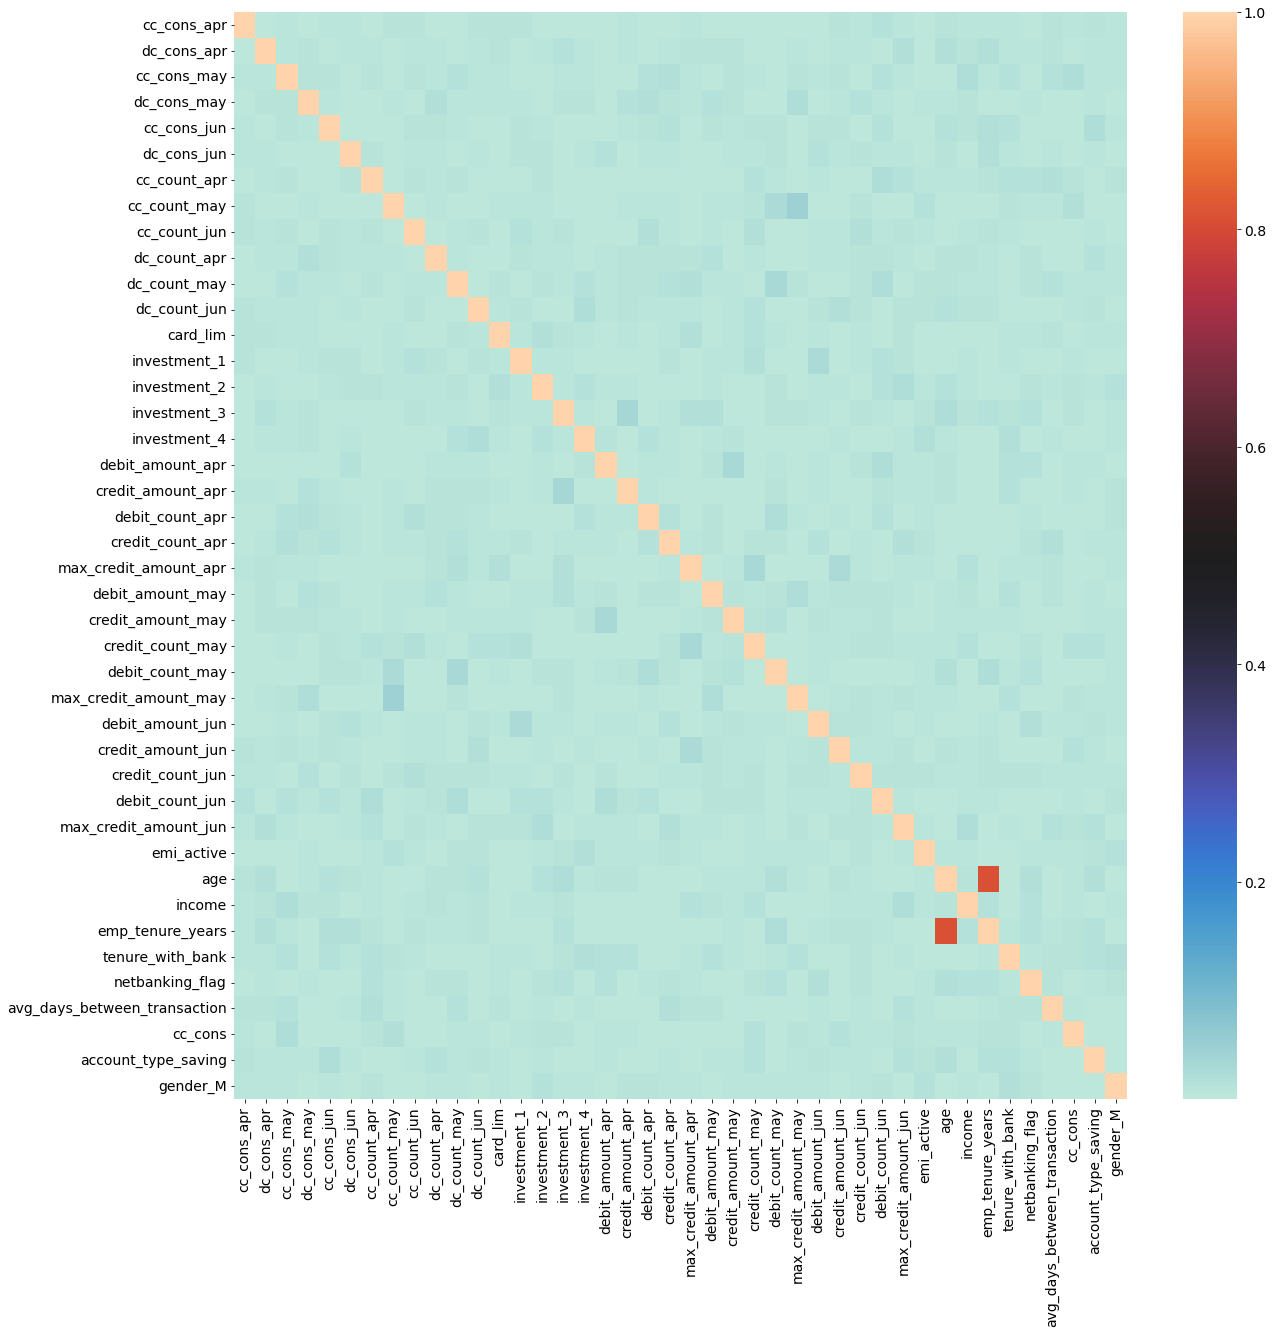

In [38]:
#BiVaraiate Analysis
#Checking correlation between variables
plt.figure(figsize = (20,20))
sns.heatmap(data.corr().abs(),cmap = 'icefire')
plt.show()

In [39]:
%cd "/kaggle/working"
cor = data.corr().abs()
cor.to_excel('Correlation.xlsx')
%cd "/kaggle/input/credit-card"

/kaggle/working
/kaggle/input/credit-card


In [40]:
#Check correlation of feature variable with target
data.corrwith(data['cc_cons']).abs().sort_values(ascending=False)

cc_cons                         1.000000
cc_cons_may                     0.021822
cc_count_may                    0.016433
credit_count_may                0.013488
credit_amount_jun               0.013026
tenure_with_bank                0.011538
investment_3                    0.011512
cc_count_apr                    0.009755
investment_2                    0.008877
max_credit_amount_may           0.008531
emp_tenure_years                0.008416
max_credit_amount_jun           0.007843
dc_count_may                    0.007711
age                             0.006965
income                          0.006610
dc_count_jun                    0.006193
cc_cons_apr                     0.006155
debit_amount_jun                0.005573
avg_days_between_transaction    0.005439
debit_count_jun                 0.005336
credit_amount_apr               0.005293
credit_count_jun                0.005108
emi_active                      0.004141
investment_1                    0.004086
debit_amount_apr

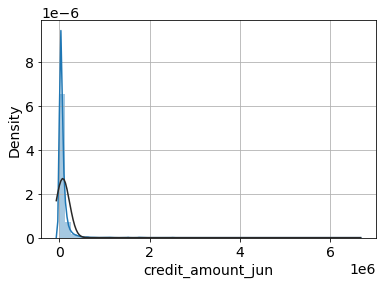

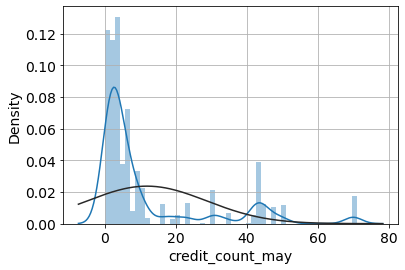

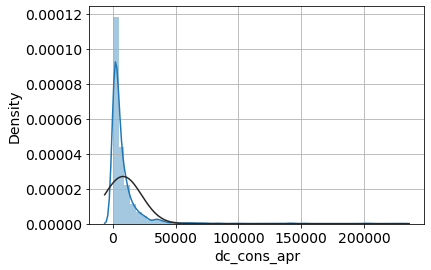

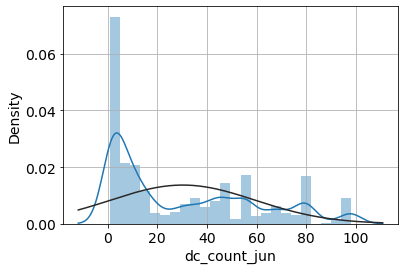

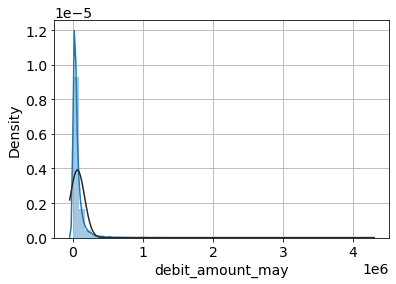

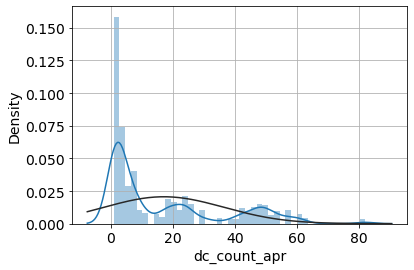

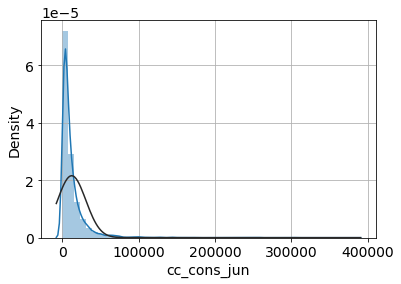

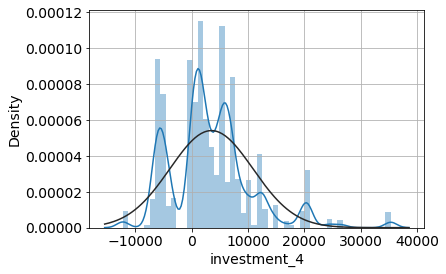

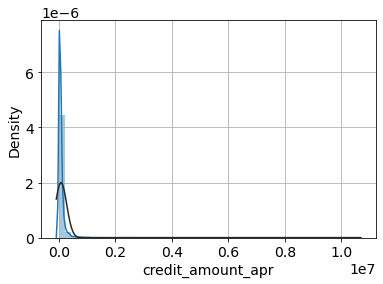

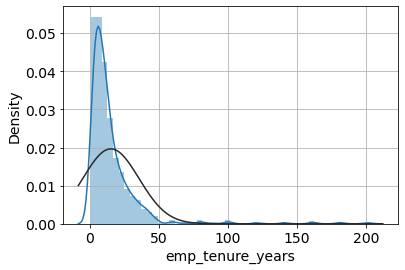

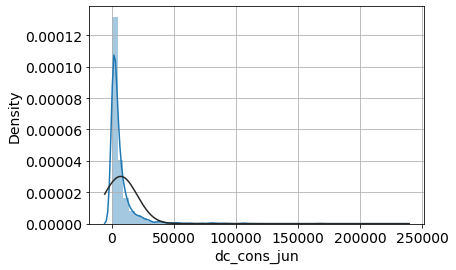

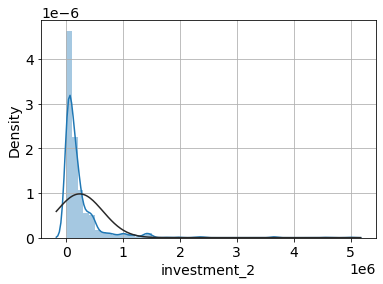

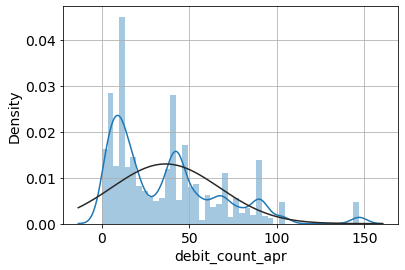

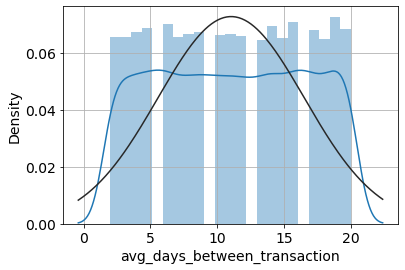

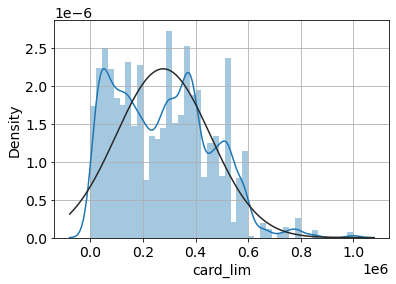

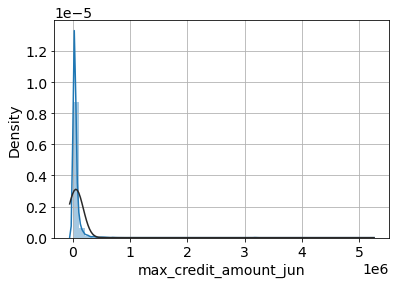

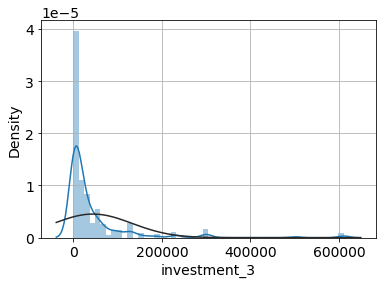

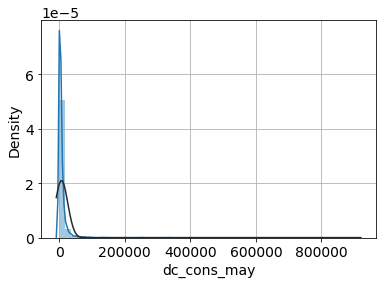

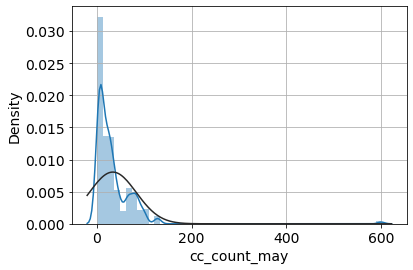

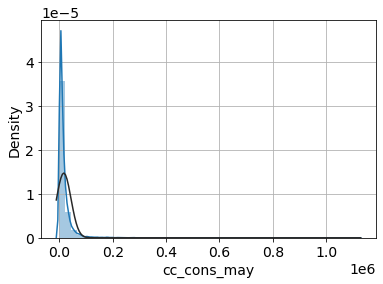

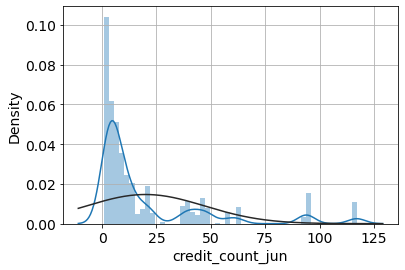

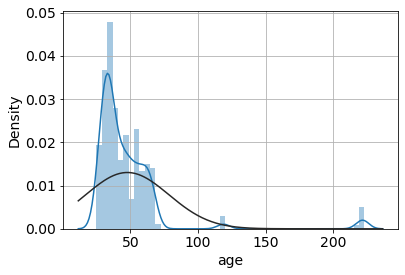

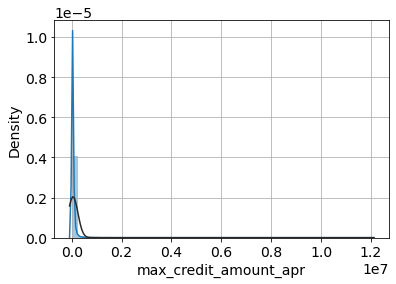

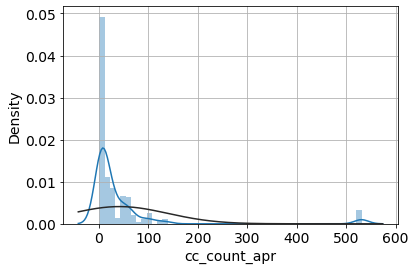

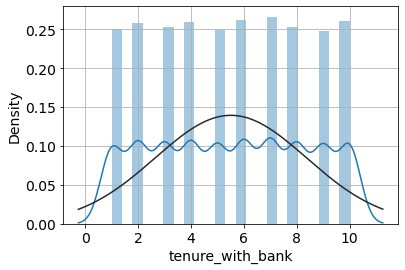

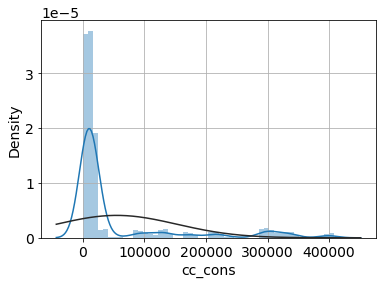

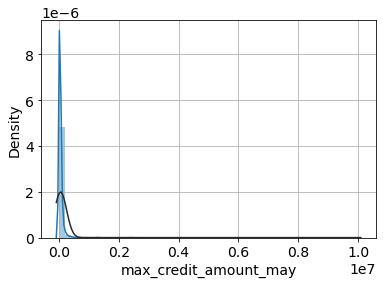

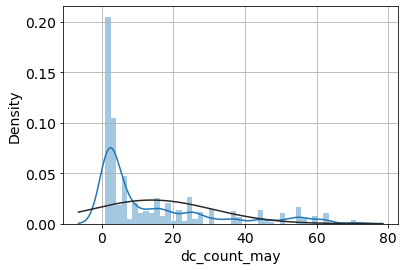

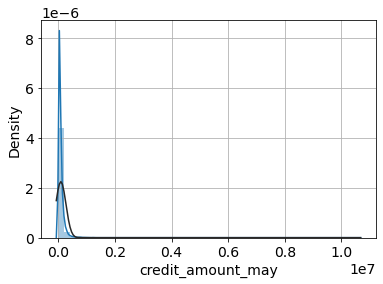

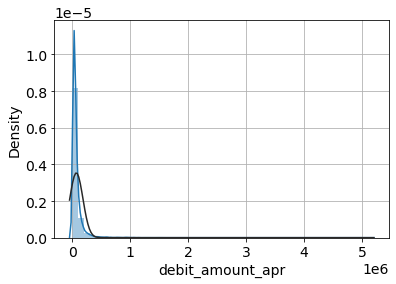

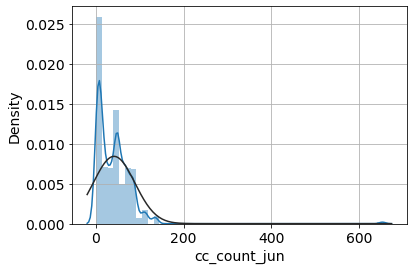

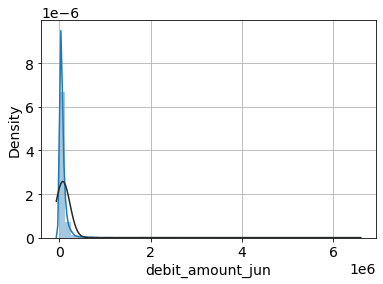

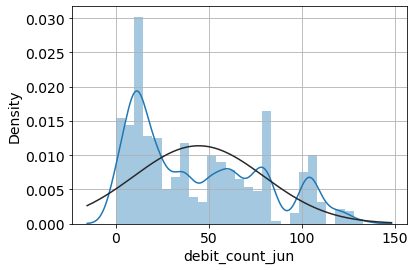

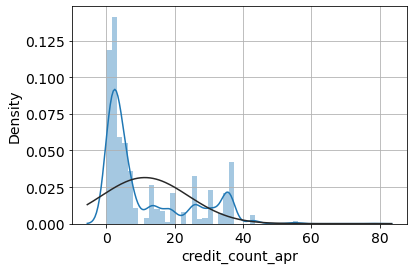

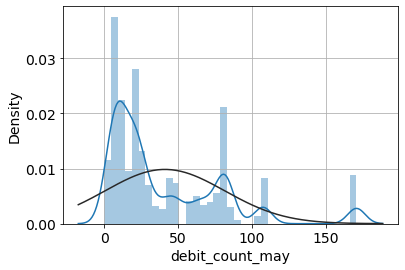

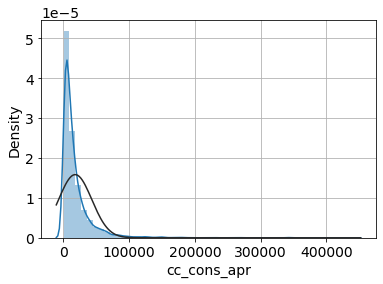

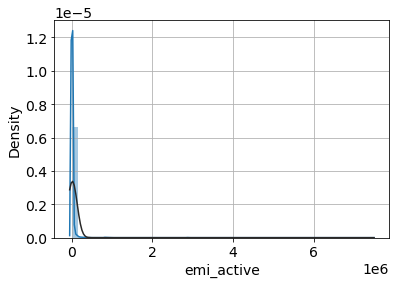

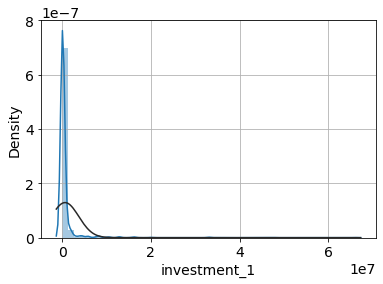

In [41]:
#Checking for normality of numerical features
from scipy.stats import norm
for i in numcol:
    sns.distplot(data[i],fit=norm)
    plt.show()


Most of the variables are not normally distributed, so we transform those variables

In [42]:
#Spltting X and y variables
data_X = data[data.columns.difference(['cc_cons'])]
data_y = data[['cc_cons']]
numcol_X = list(set(numcol)-set(['cc_cons']))
data_Xtf = data_X

In [43]:
data_X

,account_type_saving,age,avg_days_between_transaction,card_lim,cc_cons_apr,cc_cons_jun,cc_cons_may,cc_count_apr,cc_count_jun,cc_count_may,credit_amount_apr,credit_amount_jun,credit_amount_may,credit_count_apr,credit_count_jun,credit_count_may,dc_cons_apr,dc_cons_jun,dc_cons_may,dc_count_apr,dc_count_jun,dc_count_may,debit_amount_apr,debit_amount_jun,debit_amount_may,debit_count_apr,debit_count_jun,debit_count_may,emi_active,emp_tenure_years,gender_M,income,investment_1,investment_2,investment_3,investment_4,max_credit_amount_apr,max_credit_amount_jun,max_credit_amount_may,netbanking_flag,tenure_with_bank
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,0,30,20.0,358000,3412.60,4615.97,1077.36,19.0,2,10,27532.37,47635.00,42852.00,36,2,1,2909.34,6693.00,3084.50,53,42,1,25210.23,45253.64,44974.63,103.0,18,108,3448.84,7.0,1,2,331.200,130000.00,300500.0,12174.00000,28579.0,19947.00,97916.0,1,5
11491,0,37,5.0,114000,18133.76,64620.00,6123.78,4.0,1,60,50784.00,18369.00,24257.00,35,3,1,3877.00,6117.00,5597.43,4,17,1,30937.00,12912.33,117575.67,40.0,49,4,3812.69,10.2,1,1,5809950.000,3.00,610000.0,2351.00000,25379.0,20585.00,25125.0,1,8
7433,0,33,15.0,360000,6363.65,38266.00,8799.00,2.0,47,83,26345.00,26713.00,38306.00,3,47,70,735.49,2638.00,13768.00,4,42,62,12940.25,93567.51,14646.35,11.0,49,11,9432.90,3.9,1,2,27324.000,176487.60,2156.0,3735.00000,19224.0,13950.00,38546.0,1,3
14606,0,63,15.0,155000,12765.66,29063.97,16745.86,12.0,16,2,49660.00,35062.74,46132.05,26,3,43,4429.16,3711.00,6360.00,24,58,12,78122.15,176394.48,14719.00,42.0,37,1,144.61,25.8,1,1,370776.000,63000.00,26241.0,0.00000,72186.0,37018.00,180315.0,0,6
8381,1,33,9.0,362000,27819.70,1096.25,7006.50,15.0,61,13,933699.00,19056.00,37191.00,35,2,2,1944.00,1065.00,2228.50,7,80,5,6855.71,3167.00,189938.76,46.0,15,14,1887.89,6.5,1,2,10006.200,7216.53,13873.0,-4679.00000,18867.0,24274.00,13480.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,53,20.0,520000,10443.76,6633.00,7252.24,3.0,3,36,31135.00,42625.50,23692.00,2,14,1,1218.85,10107.00,3873.00,44,29,55,30608.54,487751.19,30501.77,79.0,8,8,78966.76,13.2,0,1,186189.000,24000.00,16215.0,977.00000,27608.0,82851.00,6936.0,1,9
10376,0,44,2.0,472000,29890.33,2213.08,16025.50,1.0,4,34,23797.00,34987.55,50023.00,2,11,4,6308.00,841.60,7610.00,7,2,1,39903.00,8666.01,57918.69,43.0,18,20,4762.10,2.4,1,2,24832.000,221000.00,12337.0,-6281.37988,30512.0,118110.47,202639.0,1,9
2181,0,37,8.0,44000,4148.98,44363.91,19360.26,57.0,61,23,95477.27,261432.00,35239.00,1,4,43,948.74,1801.77,494.00,24,3,3,29525.63,97896.48,25404.75,4.0,73,5,2877.33,3.4,1,2,180615.020,253000.00,25000.0,10210.00000,41085.0,49545.00,44421.0,1,9


In [44]:
#Transforming columns
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson',standardize=True, copy=True)
pt.fit(data_X)
data_Xtf = pd.DataFrame(pt.transform(data_X),index=data_X.index,columns=data_X.columns)

In [45]:

data_Xtf.head()

,account_type_saving,age,avg_days_between_transaction,card_lim,cc_cons_apr,cc_cons_jun,cc_cons_may,cc_count_apr,cc_count_jun,cc_count_may,credit_amount_apr,credit_amount_jun,credit_amount_may,credit_count_apr,credit_count_jun,credit_count_may,dc_cons_apr,dc_cons_jun,dc_cons_may,dc_count_apr,dc_count_jun,dc_count_may,debit_amount_apr,debit_amount_jun,debit_amount_may,debit_count_apr,debit_count_jun,debit_count_may,emi_active,emp_tenure_years,gender_M,income,investment_1,investment_2,investment_3,investment_4,max_credit_amount_apr,max_credit_amount_jun,max_credit_amount_may,netbanking_flag,tenure_with_bank
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,-0.422607,-1.188097,1.531944,0.562584,-0.897139,-0.305444,-1.660324,0.352886,-1.706278,-0.536600,-0.511062,-0.001707,-0.144111,1.476910,-1.399137,-1.160316,-0.228279,0.580114,-0.148224,1.396109,0.719463,-1.390781,-0.462240,-0.045590,0.098709,1.636804,-0.601984,1.426757,-0.061710,-0.339432,0.398433,0.357481,-1.558811,0.107675,1.826014,1.150504,-0.202183,-0.410050,1.069039,0.624331,-0.112865
11491,-0.422607,-0.290366,-1.099273,-0.832992,0.532028,2.087416,-0.266123,-0.823473,-1.927586,1.027906,0.030726,-0.745253,-0.605870,1.454975,-0.997759,-1.160316,-0.007734,0.508874,0.335344,-0.477786,-0.024052,-1.390781,-0.294009,-1.122360,1.059115,0.424873,0.373746,-1.508540,0.000404,0.068246,0.398433,-1.422488,2.130144,-2.582702,2.229471,-0.101984,-0.319951,-0.384790,-0.283618,0.624331,0.873207
7433,-0.422607,-0.751352,0.738311,0.571671,-0.376926,1.583763,0.035033,-1.341058,0.491129,1.340614,-0.548179,-0.469989,-0.238864,-0.487920,1.314519,1.815881,-1.235983,-0.155467,1.087927,-0.477786,0.719463,1.636648,-0.963925,0.673642,-0.874852,-0.793037,0.373746,-0.757720,0.580867,-0.958913,0.398433,0.357481,-0.111443,0.316015,-0.883724,0.076606,-0.586957,-0.685447,0.108564,0.624331,-0.844533
14606,-0.422607,1.169674,0.738311,-0.537432,0.222396,1.325219,0.578724,0.019862,-0.494844,-1.608762,0.010026,-0.256596,-0.080751,1.221445,-0.997759,1.552636,0.095759,0.113787,0.440498,0.841246,1.016118,0.539331,0.561843,1.366354,-0.870876,0.480172,0.059700,-2.232063,-1.821787,1.062613,0.398433,-1.422488,0.905270,-0.333494,0.465464,-0.411187,0.796510,0.118220,1.786426,-1.601713,0.227826
8381,2.366265,-0.751352,-0.307657,0.580734,0.916438,-1.467219,-0.154663,0.183778,0.771693,-0.327085,3.416666,-0.719176,-0.263508,1.454975,-1.399137,-0.675376,-0.531955,-0.868866,-0.407161,-0.068735,1.328678,-0.160026,-1.382174,-2.117886,1.587436,0.585257,-0.740811,-0.556453,-0.426151,-0.419235,0.398433,0.357481,-0.469411,-1.301705,0.117035,-1.174940,-0.604558,-0.249748,-0.805264,-1.601713,0.555857


In [46]:
data_ytf = np.log(data_y)
data_ytf.columns = ['log_cc_cons']

In [47]:
#Checking for outliers 
data_Xtf[numcol_X].apply(outlier_summary).T['outliers_count']

credit_amount_jun                909.0
credit_count_may                   0.0
dc_count_jun                       0.0
dc_cons_apr                      109.0
debit_amount_may                 510.0
dc_count_apr                       0.0
cc_cons_jun                      125.0
investment_4                     982.0
credit_amount_apr                750.0
emp_tenure_years                 136.0
dc_cons_jun                      110.0
investment_2                     382.0
debit_count_apr                    0.0
avg_days_between_transaction       0.0
card_lim                           0.0
max_credit_amount_jun           1333.0
investment_3                       0.0
dc_cons_may                      190.0
cc_count_may                      73.0
cc_cons_may                       67.0
credit_count_jun                   0.0
age                                0.0
max_credit_amount_apr            900.0
cc_count_apr                       0.0
tenure_with_bank                   0.0
max_credit_amount_may    

In [48]:
data_ytf.apply(outlier_summary).T['outliers_count']

log_cc_cons    3434.0
Name: outliers_count, dtype: float64

In [49]:
#Checking outliers in the data
#fig,ax = plt.subplots(6,8,figsize=(80,80),sharey=True,squeeze=False)
#for i in range(0,6):
    #for j in range(0,8):
        #sns.boxplot(data_std.iloc[0:,i+j],ax= ax[i][j])
#plt.show()

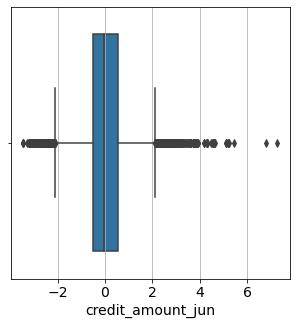

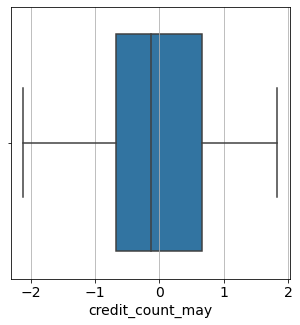

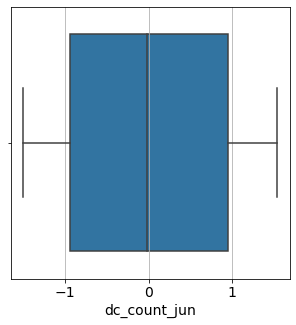

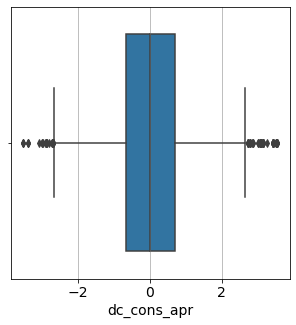

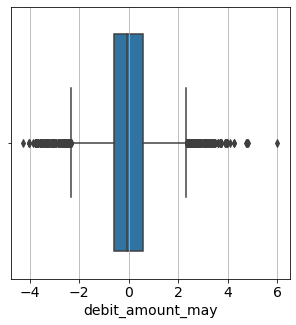

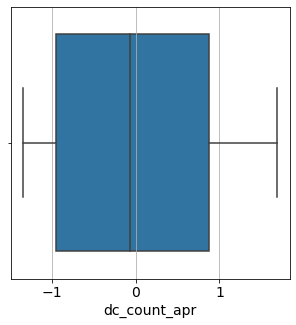

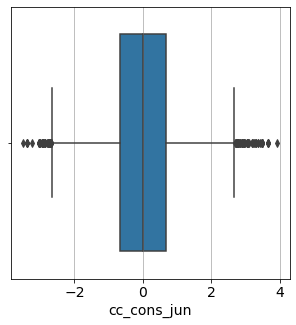

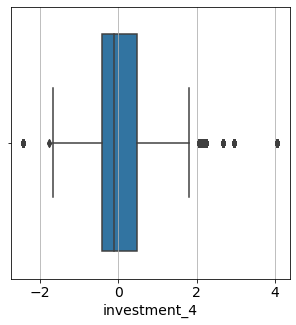

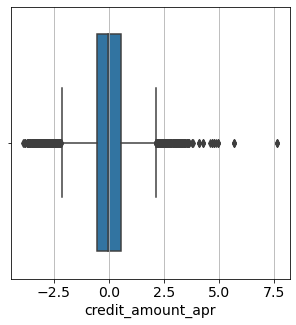

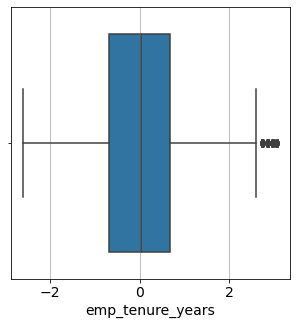

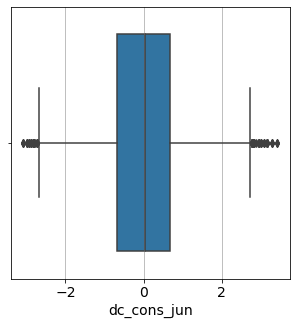

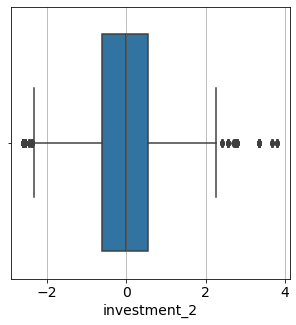

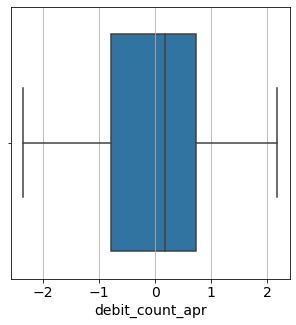

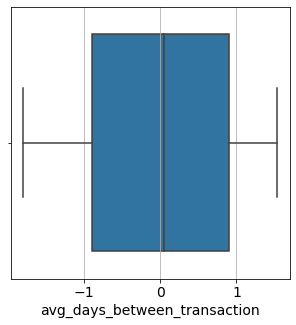

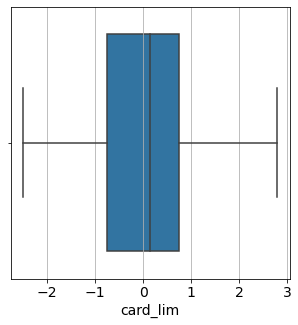

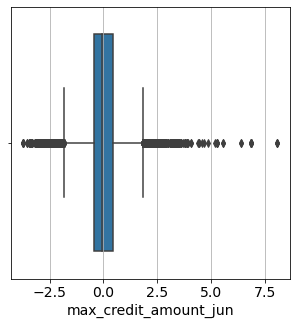

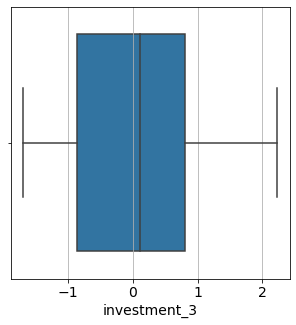

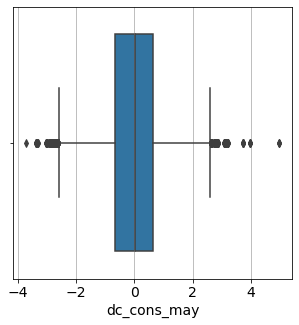

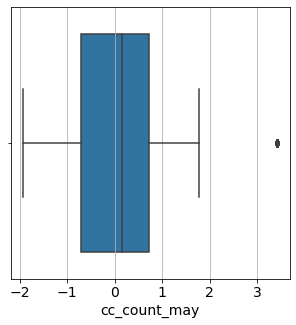

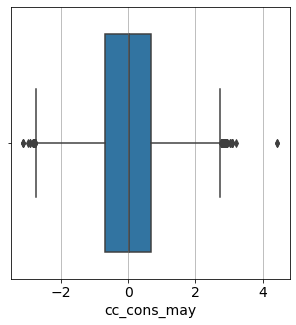

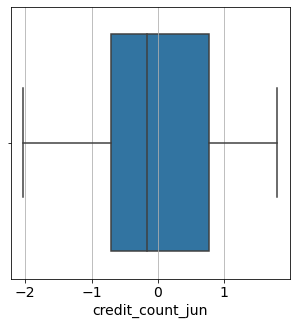

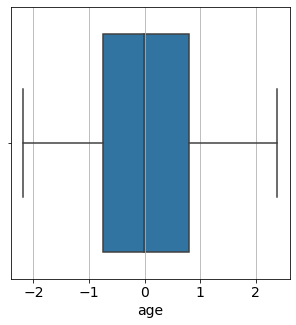

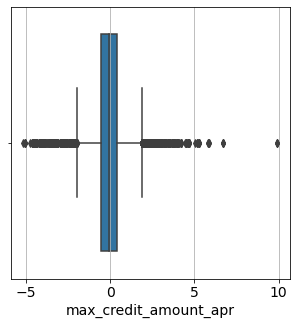

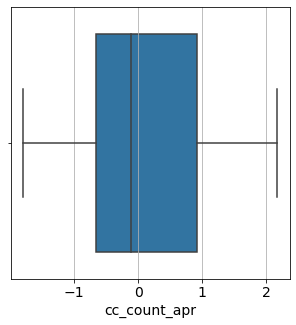

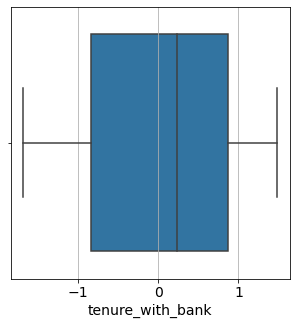

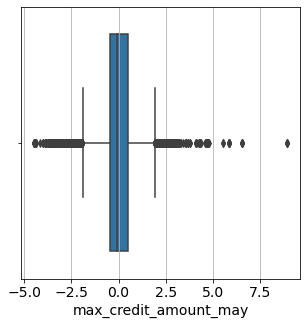

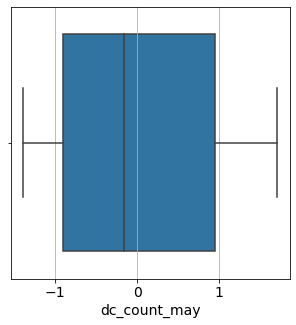

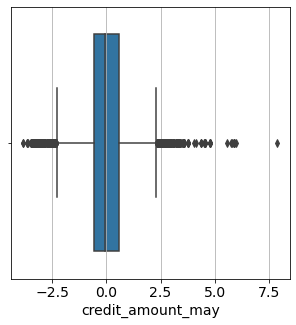

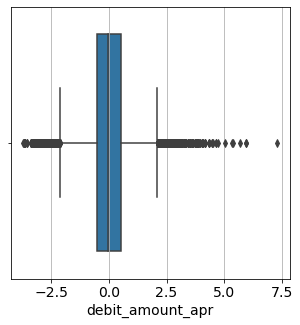

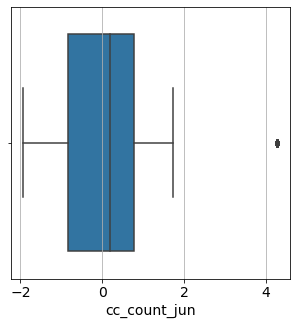

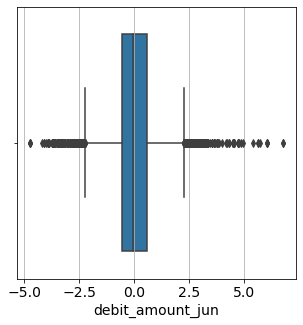

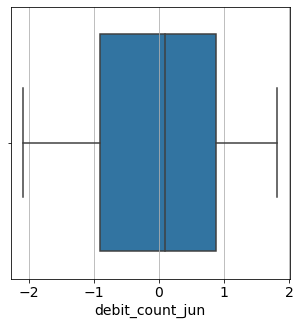

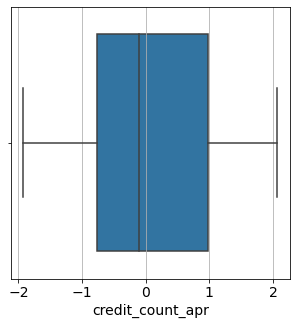

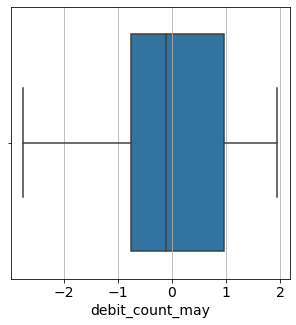

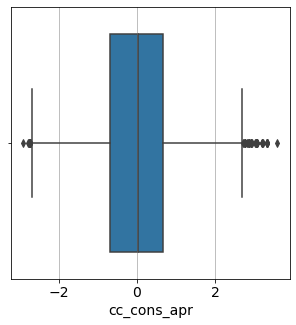

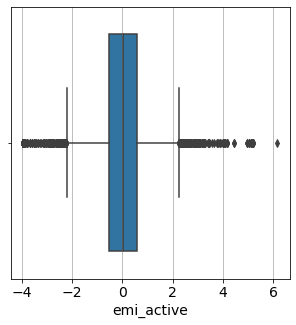

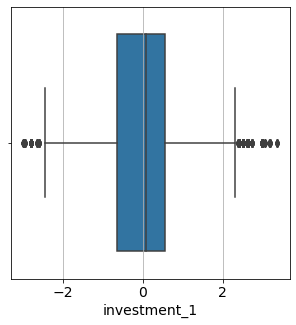

In [50]:
#Outlier Detetction - X
for i in numcol_X:
    plt.figure(figsize=(5,5))
    sns.boxplot(data_Xtf[i])
    plt.show()

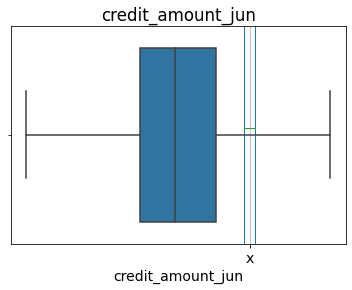

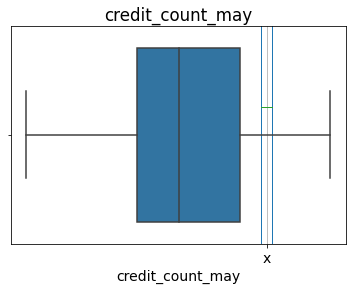

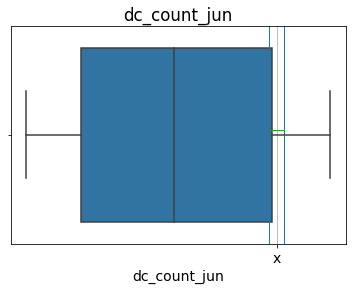

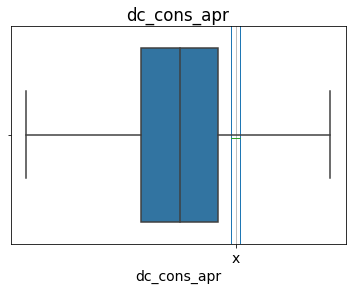

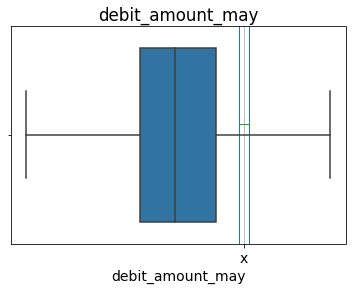

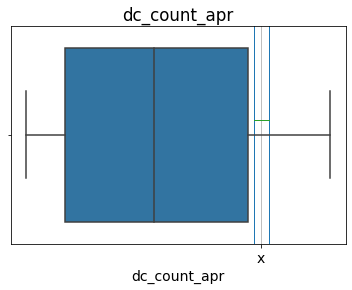

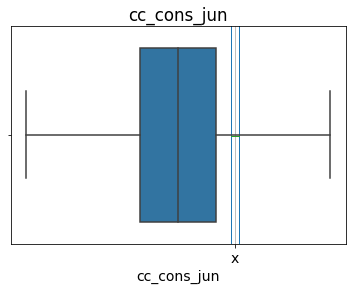

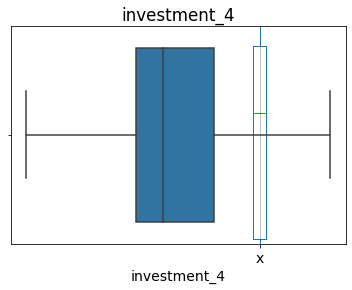

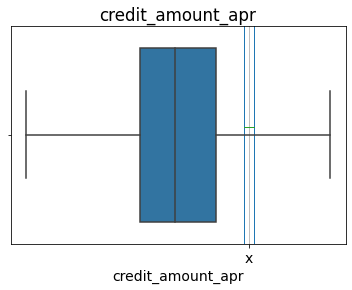

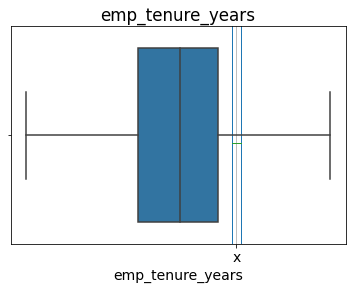

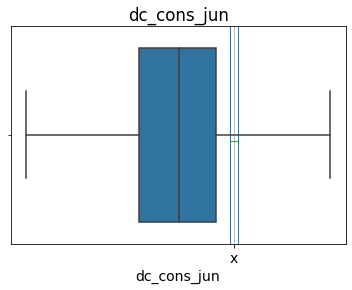

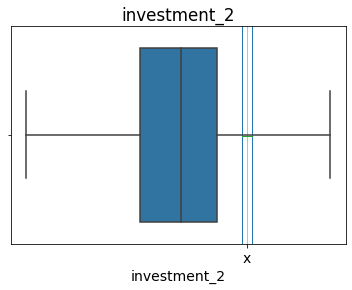

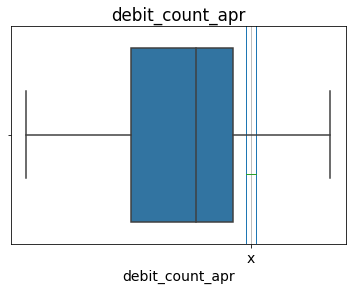

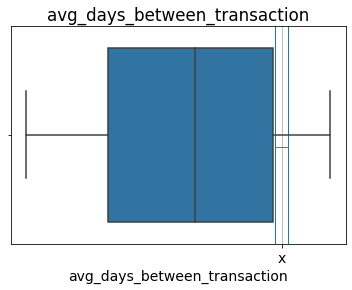

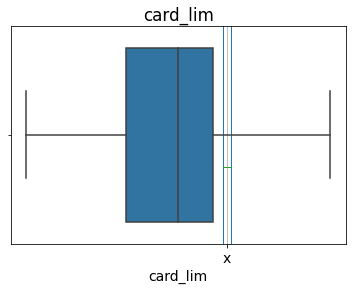

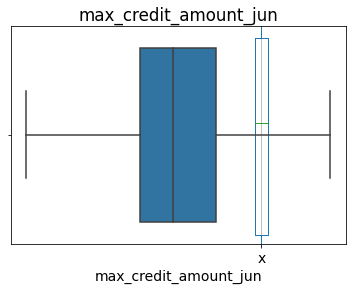

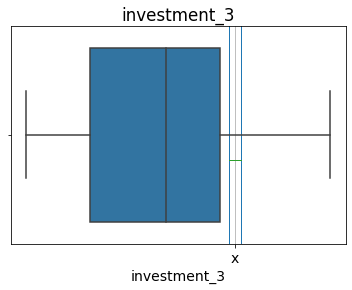

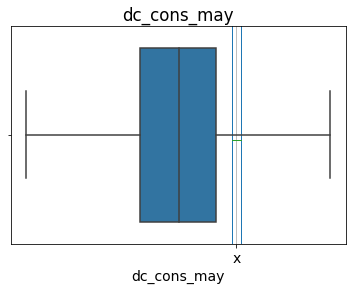

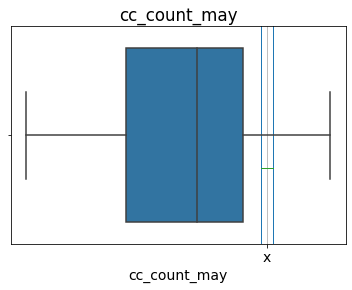

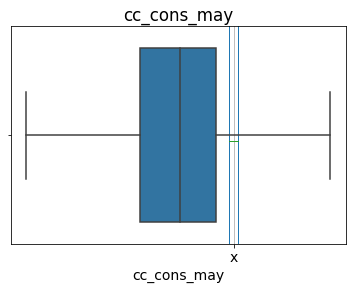

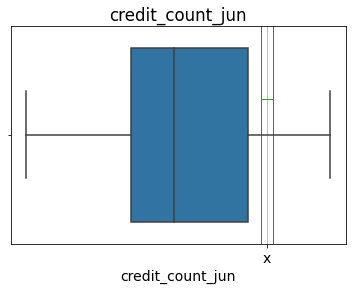

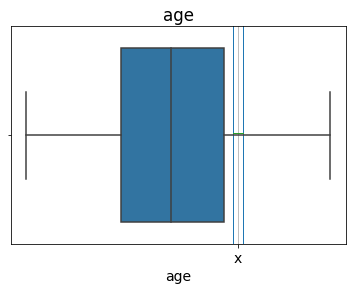

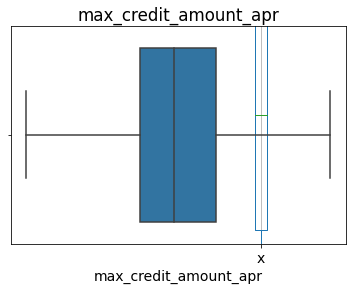

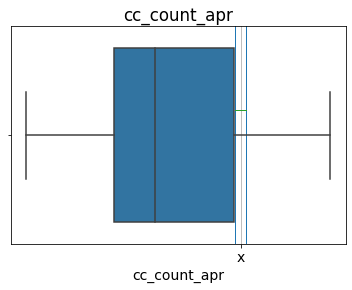

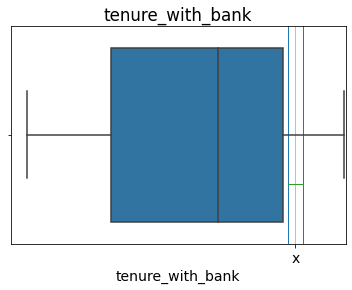

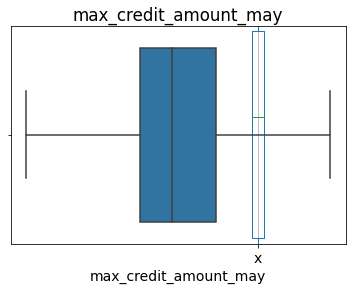

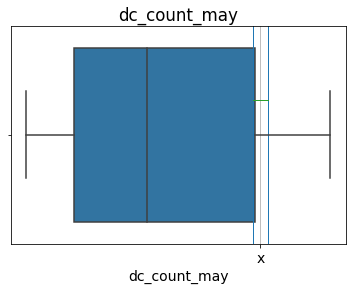

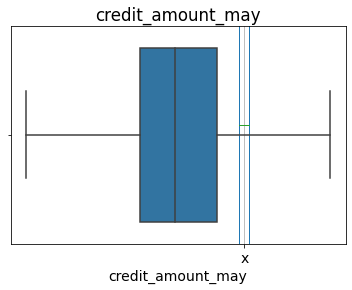

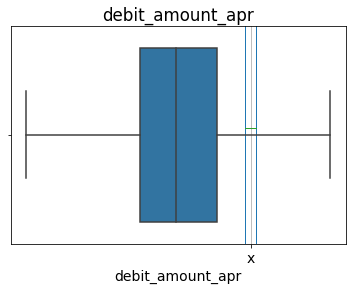

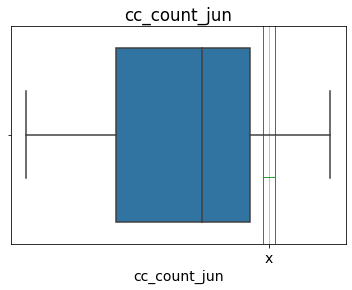

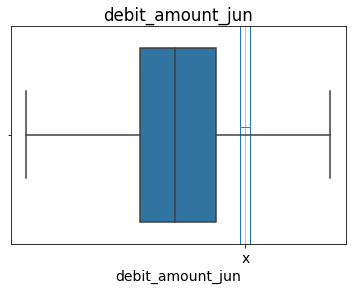

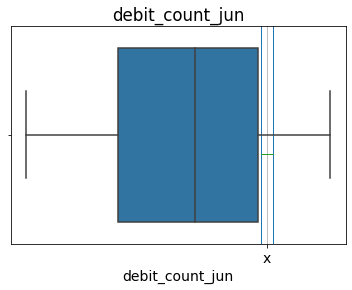

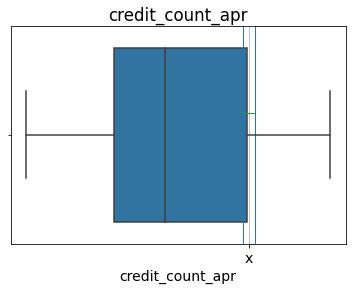

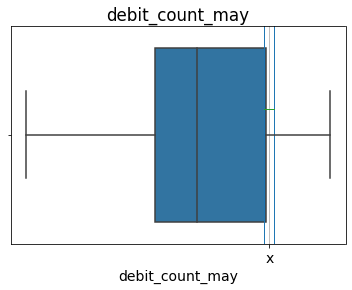

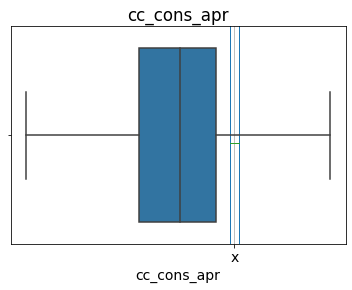

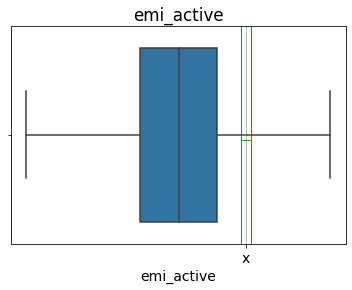

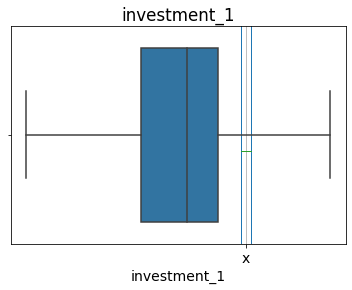

In [51]:
#Outlier treatment - X
for i in numcol_X:
    _, bp = pd.DataFrame.boxplot(data_Xtf[i], return_type='both')
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]
    data_Xtf[i].clip(lower=whiskers[0][1],upper=whiskers[1][1],inplace=True)
    sns.boxplot(data_Xtf[i])
    plt.title(i)
    plt.show()

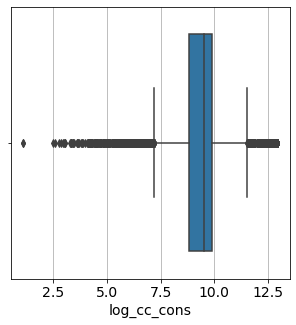

In [52]:
#Outlier Detetction - y
plt.figure(figsize=(5,5))
sns.boxplot(data_ytf['log_cc_cons'])
plt.show()

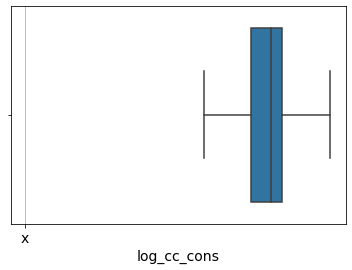

In [53]:
#Outlier treatment - y
_, bp = pd.DataFrame.boxplot(data_ytf['log_cc_cons'], return_type='both')
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]
data_ytf['log_cc_cons'].clip(lower=whiskers[0][1],upper=whiskers[1][1],inplace=True)
sns.boxplot(data_ytf['log_cc_cons'])
plt.show()

In [54]:
#Splitting train and test 

train_Xt,test_Xt,train_yt,test_yt = train_test_split(data_Xtf,data_ytf,test_size = 0.30,random_state=1)

In [55]:
train_Xt.shape


(10500, 41)

In [56]:
train_yt.shape

(10500, 1)

In [57]:
test_Xt.shape

(4500, 41)

In [58]:
test_yt.shape

(4500, 1)

# Feature Selection

In [59]:
train_t = pd.concat([train_Xt,train_yt],axis=1)

In [60]:
train_t.head()

,account_type_saving,age,avg_days_between_transaction,card_lim,cc_cons_apr,cc_cons_jun,cc_cons_may,cc_count_apr,cc_count_jun,cc_count_may,credit_amount_apr,credit_amount_jun,credit_amount_may,credit_count_apr,credit_count_jun,credit_count_may,dc_cons_apr,dc_cons_jun,dc_cons_may,dc_count_apr,dc_count_jun,dc_count_may,debit_amount_apr,debit_amount_jun,debit_amount_may,debit_count_apr,debit_count_jun,debit_count_may,emi_active,emp_tenure_years,gender_M,income,investment_1,investment_2,investment_3,investment_4,max_credit_amount_apr,max_credit_amount_jun,max_credit_amount_may,netbanking_flag,tenure_with_bank,log_cc_cons
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15396,-0.422607,1.072577,-0.690442,0.428052,-1.805253,1.224868,0.198812,-1.789104,0.556136,0.226530,1.396112,-0.972742,1.139976,1.454975,-0.710139,1.815881,-1.530021,-1.282694,-0.218350,0.267922,-0.946395,0.949607,-1.230971,0.185318,-0.790768,-0.381383,-0.601984,-0.245025,0.479050,0.793492,0.398433,2.101063,0.534064,-0.414747,0.450257,-0.411187,0.328235,-0.310457,1.903124,0.624331,-0.844533,8.879472
11997,-0.422607,-1.032054,-1.545996,1.227543,0.800213,0.217990,0.487364,0.896241,0.876987,0.294363,-1.273189,1.479782,0.538172,0.725524,-0.997759,-0.129992,-1.944109,1.568502,-0.162237,-0.316651,-1.088700,-0.010622,-1.234557,-0.590307,-1.118695,0.969000,1.011717,-0.686001,0.186214,-2.105257,0.398433,-1.422488,0.217166,0.593306,0.404942,1.180946,1.537314,-0.592189,1.092566,-1.601713,0.873207,9.064736
14015,2.366265,0.149712,1.221135,1.774314,0.365573,0.262374,-0.268951,1.068199,0.194441,0.552524,0.204098,-0.675711,-0.258336,-0.273037,1.689497,0.048507,0.954252,0.260079,1.014811,-0.477786,1.534905,1.069956,1.598056,-0.588114,-0.986507,-1.455905,-0.646642,-1.357136,2.120028,-0.402814,0.398433,0.357481,-0.355528,0.788816,-0.554290,0.902062,0.560357,-0.075352,-0.492065,0.624331,0.227826,8.692490
563,2.366265,0.425474,1.377551,0.146335,-0.676780,-0.085038,1.407194,-0.116780,1.182715,0.445965,-0.576550,-0.774745,-0.948215,-0.100569,1.475691,-2.111268,-0.847439,0.075426,1.059273,-1.337175,0.653715,-0.343623,0.979037,0.631444,-0.874852,0.969000,1.539837,-0.079807,0.912461,0.527640,0.398433,0.357481,2.130144,0.486423,0.038887,0.483649,-0.641030,-0.311739,1.125704,0.624331,-0.468967,11.541280
18763,-0.422607,-0.506160,-0.123891,-1.091541,-0.583916,0.605493,0.159202,0.569326,-0.655068,1.189110,-0.518187,0.477858,-0.062762,-0.273037,1.147006,1.552636,-1.375691,0.838214,-0.605619,1.328608,0.534291,1.069956,0.752789,-0.337722,0.094240,-1.027320,0.397698,-0.686001,2.014421,-1.224551,0.398433,2.101063,-0.663005,-0.321910,0.368801,1.808453,-0.101083,-0.445170,-0.065256,0.624331,-0.112865,8.951570


In [61]:
#Univariate Regression
RMSE = pd.DataFrame()
for i_var in train_t.columns:
    model = smf.ols('log_cc_cons~'+str(i_var), data=train_t).fit()
    train_act = train_t['log_cc_cons']
    train_pred = model.predict(train_t)
    rmse_i = np.sqrt(np.mean((train_act-train_pred)**2))
    temp = pd.DataFrame([i_var, rmse_i]).T
    RMSE = pd.concat([temp,RMSE])
    
RMSE


,0,1
0,log_cc_cons,0.0
0,tenure_with_bank,1.245066
0,netbanking_flag,1.245069
0,max_credit_amount_may,1.245066
0,max_credit_amount_jun,1.244946
0,max_credit_amount_apr,1.245064
0,investment_4,1.245054
0,investment_3,1.244649
0,investment_2,1.245029
0,investment_1,1.245048


As RMSE is almost same for univariate regression of the variables we are not taking variable based on thi step

In [62]:
regressor = RandomForestRegressor(n_jobs=-1)
rfe = RFE(estimator=regressor,n_features_to_select=8,step=1)
rfe = rfe.fit(train_Xt,train_yt)

In [63]:
imp_vars_rfe = list(train_Xt.columns[rfe.get_support()])
imp_vars_rfe

['cc_cons_apr',
 'cc_cons_jun',
 'cc_cons_may',
 'credit_amount_may',
 'dc_cons_apr',
 'dc_cons_jun',
 'dc_cons_may',
 'debit_amount_may']

In [64]:
#### Select K best using mutual information regression

SKB = SelectKBest(f_regression,k=8).fit(train_Xt, train_yt )

In [65]:
SKB.scores_

array([6.56712766e-01, 1.43067117e+00, 8.43412570e-02, 6.51473585e-01,
       8.38556778e-01, 2.79307881e-01, 4.15707089e+00, 2.82763351e+00,
       2.40532692e-01, 3.77885542e+00, 1.62662656e+00, 5.86342498e-01,
       3.47306379e+00, 1.76840677e-03, 9.57249358e-02, 3.08519088e-01,
       4.10918907e+00, 1.94556418e+00, 1.90935995e-01, 9.31025765e-01,
       5.57715917e-02, 2.55687744e+00, 4.98477482e-02, 1.12569263e-02,
       1.30163438e-01, 5.77341296e-01, 2.56020083e+00, 3.54337385e-01,
       1.46161187e+00, 2.78207423e+00, 6.31069138e-02, 7.32066885e-01,
       3.62137148e-01, 6.76956254e-01, 7.08582755e+00, 2.58508952e-01,
       8.60203220e-02, 2.07495151e+00, 5.55575200e-02, 1.11415134e-03,
       5.39367987e-02])

In [66]:

imp_vars_SKB = list(train_Xt.columns[SKB.get_support()])

In [67]:
imp_vars_SKB

['cc_cons_may',
 'cc_count_apr',
 'cc_count_may',
 'credit_amount_may',
 'dc_cons_apr',
 'debit_count_jun',
 'emp_tenure_years',
 'investment_3']

In [68]:
#Final List (from Univariate, RFE, SelectKbest) 
fxy = list(set(imp_vars_rfe + imp_vars_SKB))
len(fxy)

13

In [69]:
#### VIF
feature=fxy.copy()
a=np.inf
while a>=5:
    vif=[variance_inflation_factor(train_Xt[feature].values,i) for i in range(train_Xt[feature].shape[1])]
    vif=pd.Series(vif,name='VIF')
    fet=pd.Series(train_Xt[feature].columns,name='Feature')
    vifdf=pd.concat([vif,fet],axis=1).sort_values(by="VIF")
    a=vifdf['VIF'].max()
    if a<=5:
        break
    feature=list(vifdf[:-1]["Feature"])


In [70]:
len(feature)

13

In [71]:
feature

['cc_cons_may',
 'credit_amount_may',
 'dc_cons_apr',
 'debit_amount_may',
 'cc_count_apr',
 'debit_count_jun',
 'cc_cons_jun',
 'dc_cons_may',
 'emp_tenure_years',
 'investment_3',
 'cc_cons_apr',
 'dc_cons_jun',
 'cc_count_may']

In [72]:
features = ['cc_count_apr',
 'cc_cons_jun',
 'debit_amount_may',
 'credit_amount_may',
 'dc_cons_jun',
 'investment_3',
 'cc_cons_apr',
 'dc_cons_may',
 'debit_count_jun',
 'cc_count_may',
 'emp_tenure_years',
 'cc_cons_may',
 'dc_cons_apr']

In [73]:
vifdf

,VIF,Feature
12,1.000428,cc_count_may
10,1.000463,cc_cons_apr
7,1.000709,dc_cons_may
6,1.000835,cc_cons_jun
1,1.000860,credit_amount_may
8,1.000917,emp_tenure_years
2,1.000920,dc_cons_apr
5,1.000992,debit_count_jun
11,1.001002,dc_cons_jun
4,1.001297,cc_count_apr


In [74]:
train_Xf = train_Xt[features]
test_Xf = test_Xt[features]
train_yf = train_yt['log_cc_cons']
test_yf = test_yt['log_cc_cons']

# Modelling


## Defining the metrics

In [75]:
def rmspe(y_act,y_pred):
    e = (np.sqrt(np.mean(np.square((y_act-y_pred)/y_act))))*100
    return e
def mape(y_act,y_pred):
    e = np.mean(np.abs((y_act- y_pred)/(y_act)))*100
    return e
def rmse(y_act,y_pred):
    e = np.sqrt(np.mean((((y_act- y_pred))**2)))
    return e
def mae(y_act,y_pred):
    e = np.mean(np.abs((y_act- y_pred)))
    return e

def model_metrics(tr_y,tr_pred,te_y,te_pred):
    df =pd.DataFrame({'MAE':[mae(tr_y,tr_pred),mae(te_y,te_pred)],
                                  'RMSE':[rmse(tr_y,tr_pred),rmse(te_y,te_pred)],
                                  'MAPE':[mape(tr_y,tr_pred),mape(te_y,te_pred)],
                                  'RMSPE':[rmspe(tr_y,tr_pred),rmspe(te_y,te_pred)]},
                                  index = ['Train','Test'])
    return df

## Random Forest Regression

In [76]:
rf_base =  RandomForestRegressor(n_jobs=-1)
rf_base.fit(train_Xf, train_yf)

RandomForestRegressor(n_jobs=-1)

In [77]:
train_pred = rf_base.predict(train_Xf)
test_pred = rf_base.predict(test_Xf)

In [78]:
rf_base_metrics = model_metrics(train_yf,train_pred,test_yf,test_pred)
rf_base_metrics

,MAE,RMSE,MAPE,RMSPE
Train,0.363030,0.472435,3.880491,5.178686
Test,0.976777,1.266700,10.510781,13.999019


In [79]:
#Grid Search CV

param_grid = {'n_estimators':[50,100] ,'max_depth':[2,3,4], 'max_features':[4,5,6]}

In [80]:
grid=GridSearchCV(estimator=RandomForestRegressor(),param_grid=param_grid,n_jobs=-1,cv=3,verbose=True,scoring = 'neg_mean_absolute_percentage_error')
grid.fit(train_Xf,train_yf)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4], 'max_features': [4, 5, 6],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_percentage_error', verbose=True)

In [81]:
grid.best_params_

{'max_depth': 2, 'max_features': 6, 'n_estimators': 100}

In [82]:
grid.best_score_

-0.10171099314895575

In [83]:
rf_reg = RandomForestRegressor(n_estimators=50 , max_depth = 3, max_features=5, n_jobs=-1)
rf_reg = rf_reg.fit(train_Xf, train_yf)

In [84]:
train_pred = rf_reg.predict(train_Xf)
test_pred = rf_reg.predict(test_Xf)

In [85]:
rf_eval = model_metrics(train_yf,train_pred,test_yf,test_pred)
rf_eval

,MAE,RMSE,MAPE,RMSPE
Train,0.947215,1.238363,10.129025,13.578292
Test,0.958363,1.252143,10.314383,13.840196


In [86]:
metrics.r2_score(train_yf,train_pred)

0.010742842396454733

In [87]:
metrics.r2_score(test_yf,test_pred)

-0.0010537603002294116

## KNN Regression

In [88]:
knn_base = KNeighborsRegressor(n_jobs=-1).fit(train_Xf,train_yf)

In [89]:
train_pred = knn_base.predict(train_Xf)
test_pred = knn_base.predict(test_Xf)

In [90]:
knn_b_eval = model_metrics(train_yf,train_pred,test_yf,test_pred)
knn_b_eval

,MAE,RMSE,MAPE,RMSPE
Train,0.896432,1.123295,9.559901,12.261323
Test,1.086908,1.369423,11.657696,15.057383


In [91]:
#Hyperparameter tuning
param_grid = {'n_neighbors':[5,6,7,8,9,10],
    'weights':['uniform','distance']}


In [92]:
grid = GridSearchCV(estimator=KNeighborsRegressor(),param_grid=param_grid,cv=3,n_jobs=-1,scoring ='neg_mean_absolute_percentage_error')
grid.fit(train_Xf,train_yf)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_percentage_error')

In [93]:
grid.best_params_

{'n_neighbors': 10, 'weights': 'uniform'}

In [94]:
grid.best_score_

-0.10878983598637475

In [95]:
knn_model=KNeighborsRegressor(n_neighbors =10, weights='uniform').fit(train_Xf,train_yf)

In [96]:
train_pred = knn_model.predict(train_Xf)
test_pred = knn_model.predict(test_Xf)

In [97]:
knn_eval = model_metrics(train_yf,train_pred,test_yf,test_pred)
knn_eval

,MAE,RMSE,MAPE,RMSPE
Train,0.934394,1.189090,9.970901,13.001411
Test,1.028019,1.304835,11.029075,14.351973


In [98]:
metrics.r2_score(train_yf,train_pred)

0.08790032053417096

In [99]:
metrics.r2_score(test_yf,test_pred)

-0.08707911002182755

## Decision Tree Regressor

In [100]:
DT_base = DecisionTreeRegressor().fit(train_Xf,train_yf)


In [101]:
train_pred = DT_base.predict(train_Xf)
test_pred  =  DT_base.predict(test_Xf)

In [102]:
DT_base_eval = model_metrics(train_yf,train_pred,test_yf,test_pred)
DT_base_eval

,MAE,RMSE,MAPE,RMSPE
Train,1.784816e-17,1.748650e-16,1.613072e-16,1.558584e-15
Test,1.417074e+00,1.799825e+00,1.519560e+01,1.965537e+01


In [103]:
#Hyper parameter tuning
param_grid = {
    'max_depth':[3,4,5],
    'max_features':[11,12,13],
    'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]
             }

In [104]:
grid = GridSearchCV(estimator=DecisionTreeRegressor(random_state=121),param_grid=param_grid,cv=3,n_jobs=-1,verbose =1,scoring='neg_mean_absolute_percentage_error')
grid.fit(train_Xf,train_yf)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=121), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'max_features': [11, 12, 13],
                         'min_impurity_decrease': [5e-05, 0.0001, 0.0002,
                                                   0.0005, 0.001, 0.0015, 0.002,
                                                   0.005, 0.01]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [105]:
DT_bestparams = grid.best_params_
DT_bestparams

{'max_depth': 3, 'max_features': 11, 'min_impurity_decrease': 0.005}

In [106]:
grid.best_score_

-0.10182992899954298

In [107]:
#Building the tree with best hyper parameters

DT_model = DecisionTreeRegressor(**DT_bestparams,random_state=121).fit(train_Xf,train_yf)


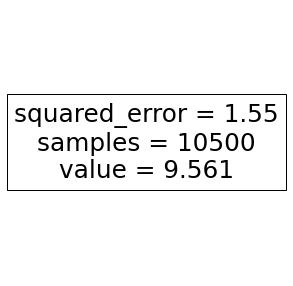

In [108]:
from sklearn import tree
fig = plt.figure(figsize=(5,5))
_ = tree.plot_tree(DT_model, 
                   feature_names=train_Xf.columns,  
                   filled=True)

In [109]:
text_representation = tree.export_text(DT_model)
print(text_representation)

|--- value: [9.56]



In [110]:
train_pred = DT_model.predict(train_Xf)
test_pred = DT_model.predict(test_Xf)

In [111]:
DT_eval = model_metrics(train_yf,train_pred,test_yf,test_pred) 
DT_eval

,MAE,RMSE,MAPE,RMSPE
Train,0.952076,1.245069,10.181058,13.651688
Test,0.957078,1.251683,10.300857,13.837520


## XGBoost Regressor

In [112]:
xg_base = XGBRegressor().fit(train_Xf,train_yf)

In [113]:
train_pred = xg_base.predict(train_Xf)
test_pred = xg_base.predict(test_Xf)

In [114]:
xgbase_eval = model_metrics(train_yf,train_pred,test_yf,test_pred)
xgbase_eval

,MAE,RMSE,MAPE,RMSPE
Train,0.577236,0.764521,6.162031,8.362710
Test,1.062369,1.346137,11.406531,14.818049


In [115]:
#Hyper parameter tuning
param_grid = {'n_estimators':[50,100],
            'learning_rate': [0.1,0.2,0.3],
            'gamma':[0.1,0.2],
            'max_depth':[2,3,4],
             }


In [116]:
grid = GridSearchCV(estimator=XGBRegressor(),param_grid=param_grid,cv=3,n_jobs=-1,verbose =1,scoring='neg_mean_absolute_percentage_error')
grid.fit(train_Xf,train_yf)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [117]:
xg_bestparams = grid.best_params_
xg_bestparams

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}

In [118]:
grid.best_score_

-0.10118816293821387

In [119]:
xgb_model = XGBRegressor(**xg_bestparams).fit(train_Xf,train_yf)

In [120]:
train_pred = xgb_model.predict(train_Xf)
test_pred  = xgb_model.predict(test_Xf)

In [121]:
xgb_eval = model_metrics(train_yf,train_pred,test_yf,test_pred)
xgb_eval

,MAE,RMSE,MAPE,RMSPE
Train,0.942766,1.235281,10.031245,13.412445
Test,0.958831,1.254194,10.268328,13.727981


## Comparing the models

In [122]:
x = pd.concat([rf_eval,
knn_eval,
DT_eval,
xgb_eval],axis=0)

In [123]:
x.index = ['RF_Train', 'RF_Test', 'KNN_Train', 'KNN_Test', 'DT_Train', 'DT_Test', 'XGB_Train', 'XGB_Test']

In [124]:
x

,MAE,RMSE,MAPE,RMSPE
RF_Train,0.947215,1.238363,10.129025,13.578292
RF_Test,0.958363,1.252143,10.314383,13.840196
KNN_Train,0.934394,1.189090,9.970901,13.001411
KNN_Test,1.028019,1.304835,11.029075,14.351973
DT_Train,0.952076,1.245069,10.181058,13.651688
DT_Test,0.957078,1.251683,10.300857,13.837520
XGB_Train,0.942766,1.235281,10.031245,13.412445
XGB_Test,0.958831,1.254194,10.268328,13.727981


#### All the models have almost same error metrics.

## Predicting  credit card consumption for the real world data

In [125]:
#EDA and Data prep
real.head()

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17591,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,Y,1170.49,current,M,37,MEDIUM,11.9,4,575.0,1,16.0,NaN
13541,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,Y,16447.45,current,M,33,MEDIUM,7.8,6,394.0,0,19.0,NaN
13431,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,Y,2622.28,current,M,53,LOW,33.0,10,324.0,1,15.0,NaN
8687,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,Y,340.79,current,M,33,MEDIUM,7.8,5,370.0,1,7.0,NaN
14727,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,Y,2812.20,current,M,62,LOW,12.6,9,505.0,1,3.0,NaN


In [126]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 17591 to 12413
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cc_cons_apr                   5000 non-null   float64
 1   dc_cons_apr                   5000 non-null   float64
 2   cc_cons_may                   4999 non-null   float64
 3   dc_cons_may                   5000 non-null   float64
 4   cc_cons_jun                   5000 non-null   float64
 5   dc_cons_jun                   4999 non-null   float64
 6   cc_count_apr                  5000 non-null   float64
 7   cc_count_may                  5000 non-null   int64  
 8   cc_count_jun                  5000 non-null   int64  
 9   dc_count_apr                  5000 non-null   int64  
 10  dc_count_may                  5000 non-null   int64  
 11  dc_count_jun                  5000 non-null   int64  
 12  card_lim                      5000 non-null   int64  
 13

In [127]:
real.columns = real.columns.str.lower()

In [128]:
real_X = real[real.columns.difference(['cc_cons'])]

In [129]:
#Detecting misiing values
real_X.isna().sum().sum()

8

In [130]:
#treating missing values
real_X = real_X.apply(missing_imputation)

In [131]:
real_X.duplicated().sum()

0

In [132]:
dummy

['loan_enq', 'account_type', 'gender']

In [133]:
real_X['income'] = np.where(real_X['income']=='HIGH',3,np.where(real_X['income']=='MEDIUM',2,1))

In [134]:
real_X = create_dummies(real_X,dummy)

In [135]:
set(real_X.columns)-set(data_X.columns)

{'personal_loan_active',
 'personal_loan_closed',
 'region_code',
 'vehicle_loan_active',
 'vehicle_loan_closed'}

In [136]:
real_X= real_X.drop(columns =['personal_loan_active',
 'personal_loan_closed',
 'region_code',
 'vehicle_loan_active',
 'vehicle_loan_closed'])

In [137]:
#Transforming X variables
real_Xtf = pd.DataFrame(pt.transform(real_X),index = real_X.index,columns=real_X.columns)

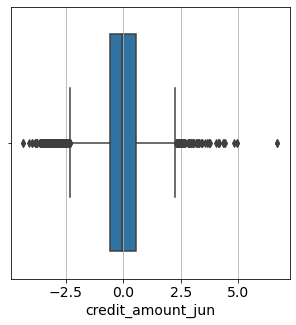

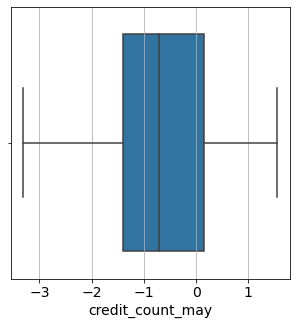

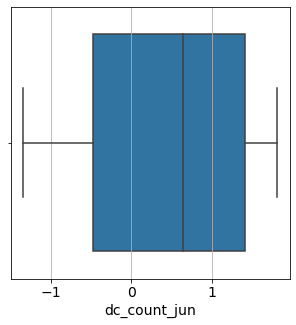

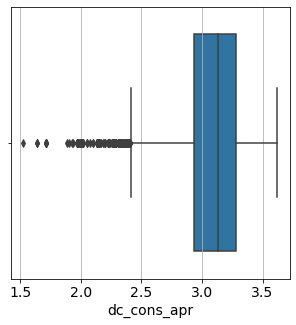

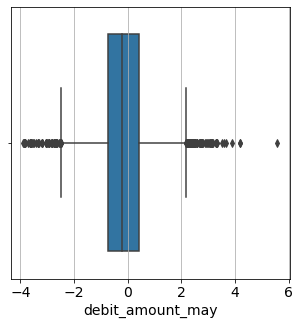

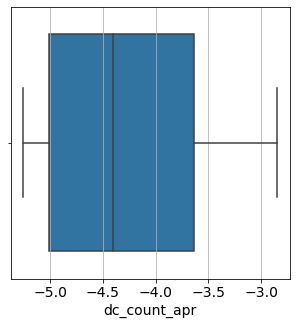

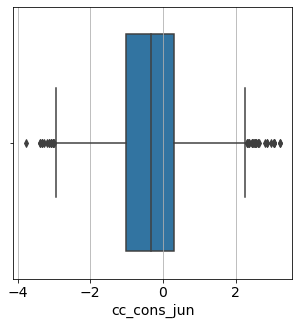

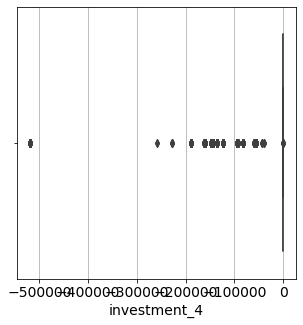

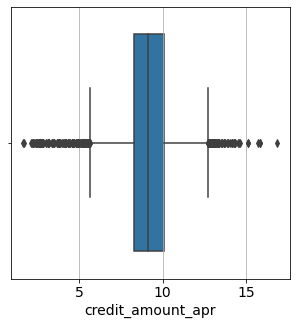

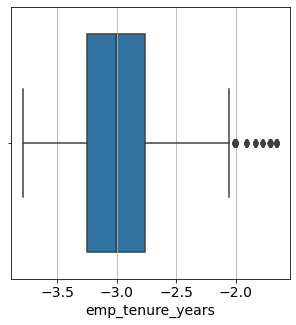

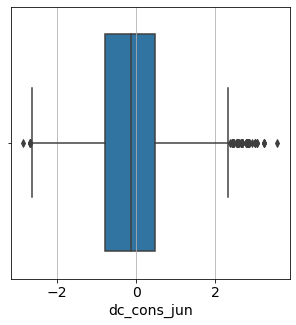

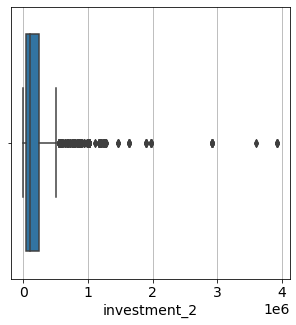

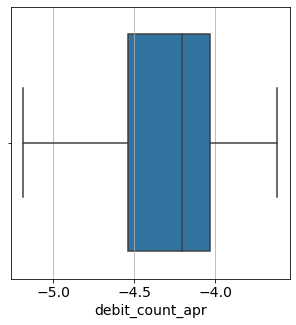

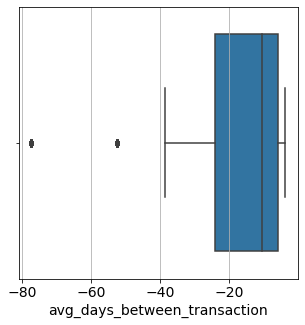

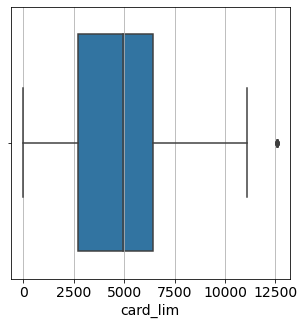

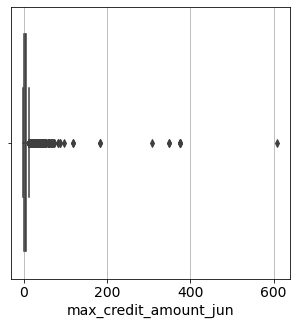

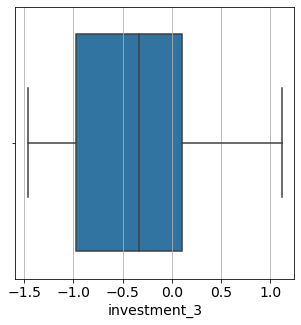

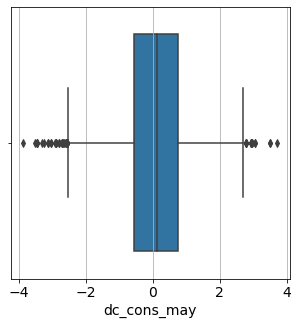

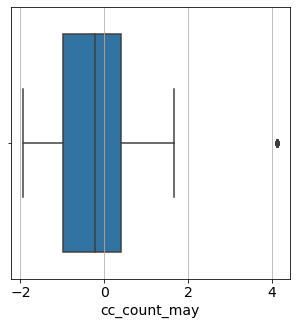

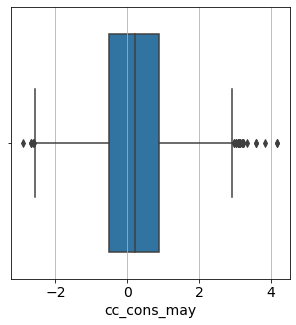

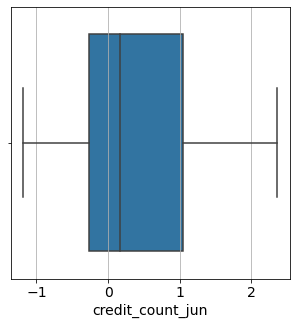

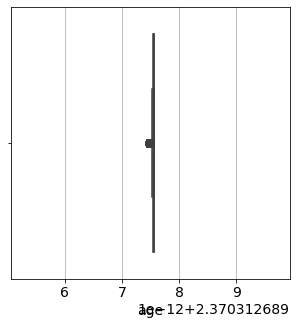

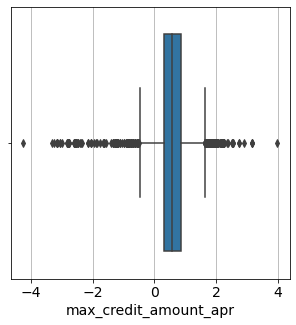

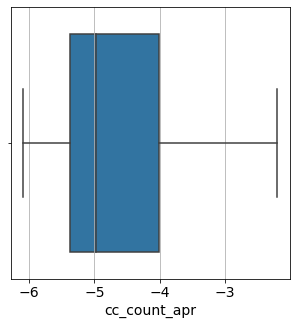

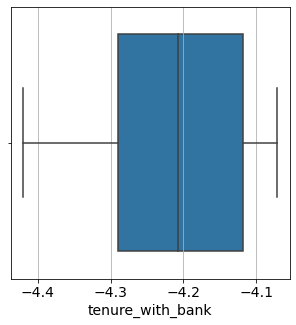

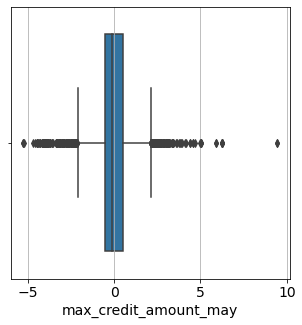

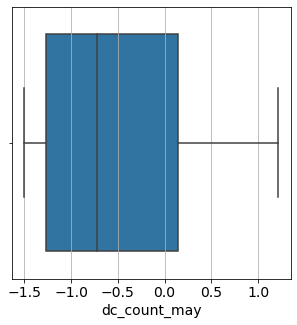

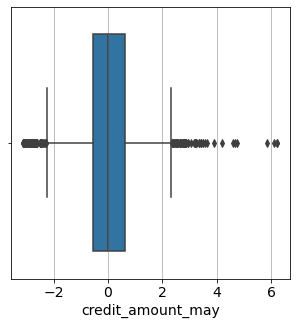

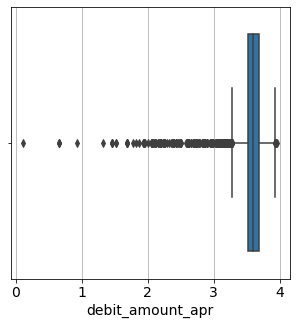

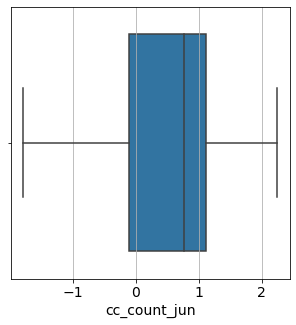

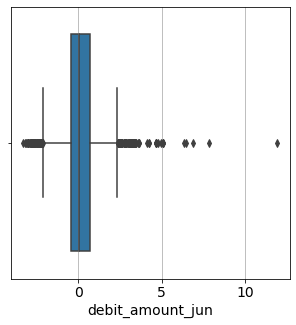

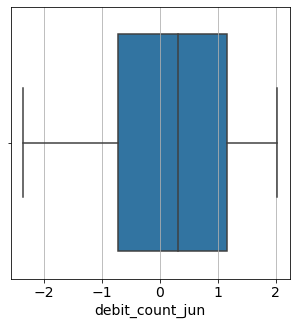

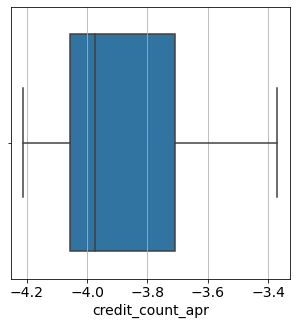

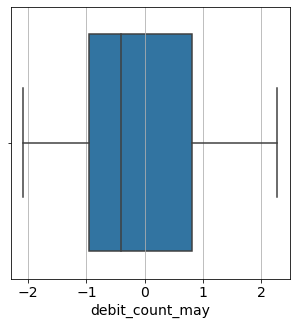

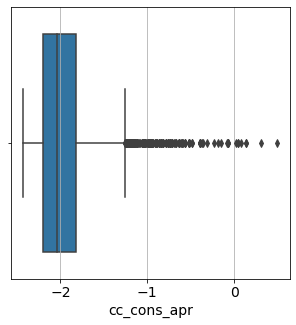

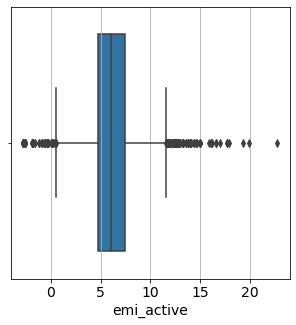

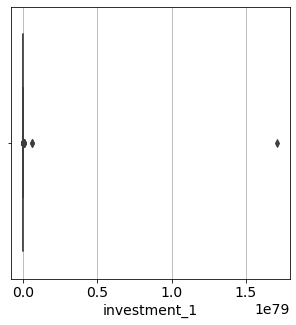

In [138]:
#Outlier Detetction - X
for i in numcol_X:
    plt.figure(figsize=(5,5))
    sns.boxplot(real_Xtf[i])
    plt.show()

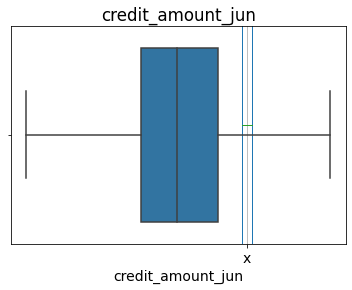

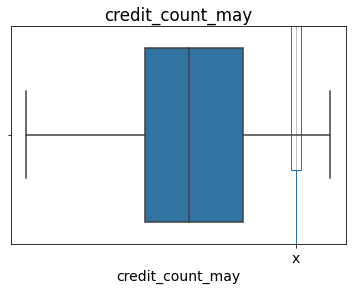

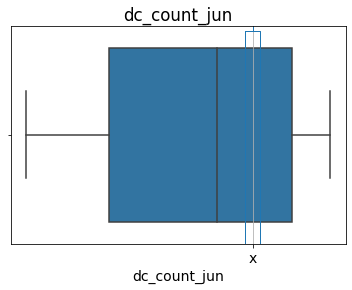

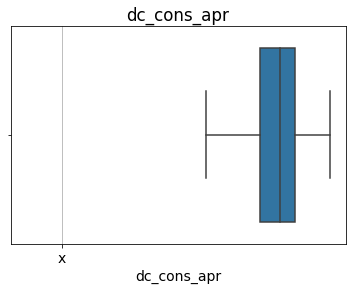

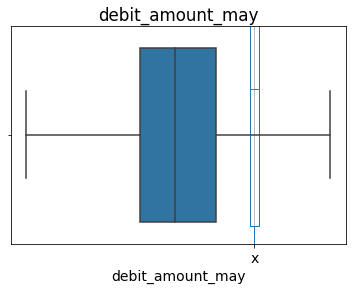

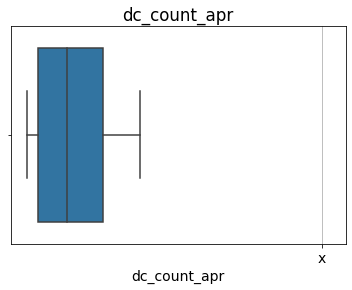

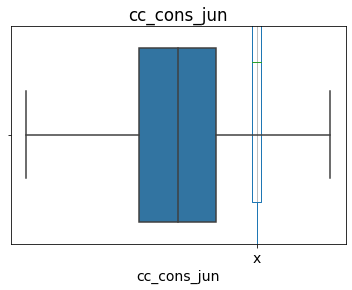

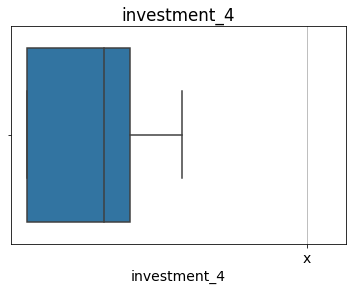

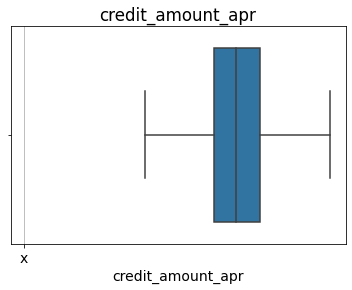

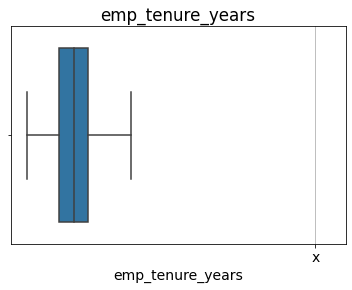

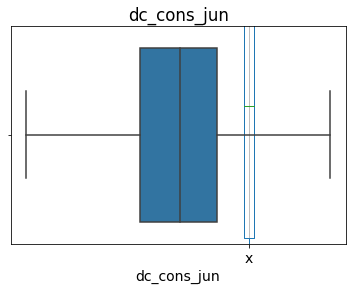

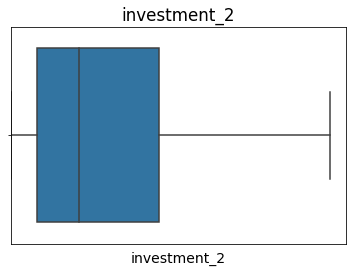

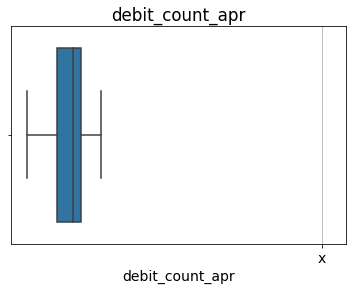

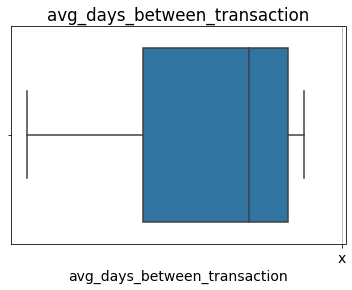

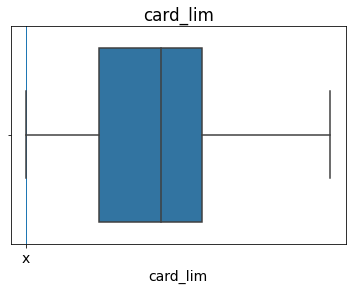

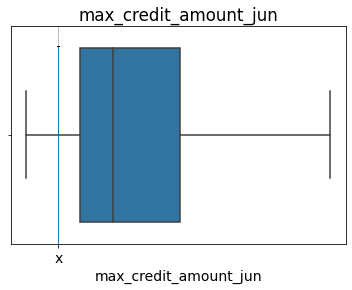

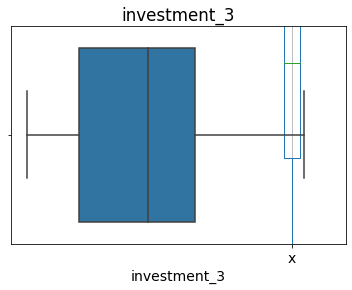

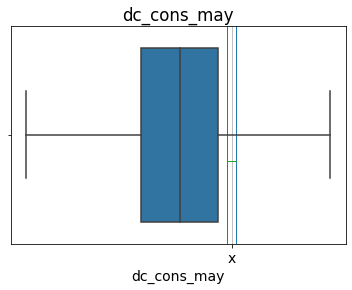

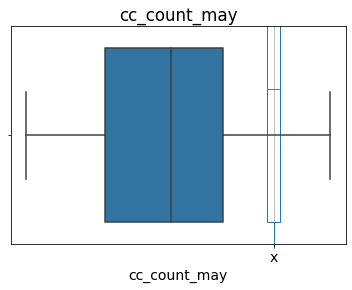

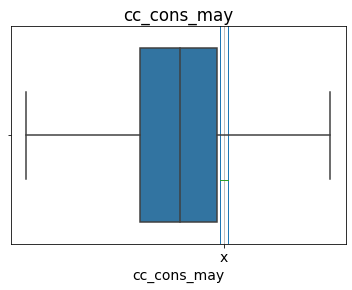

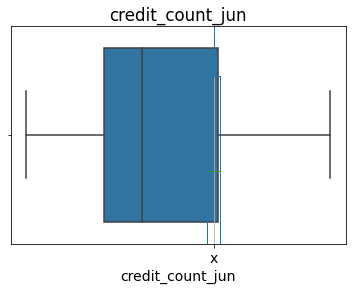

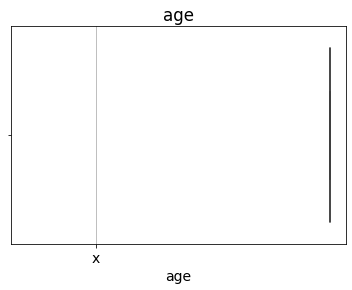

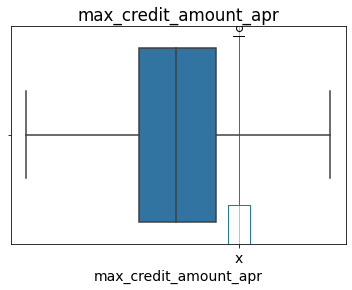

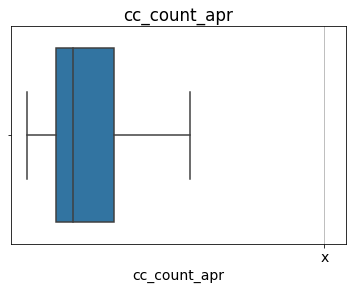

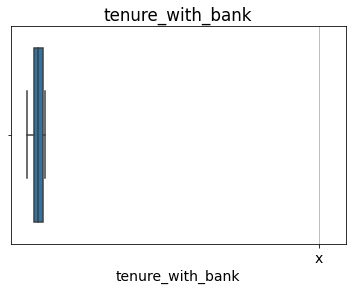

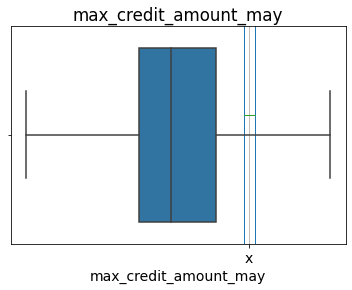

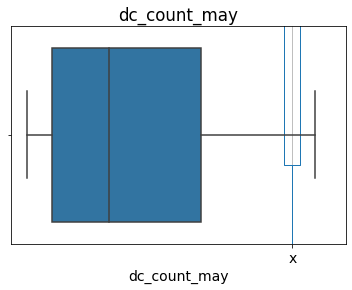

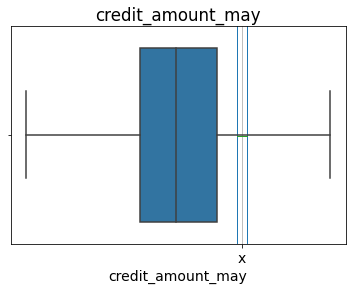

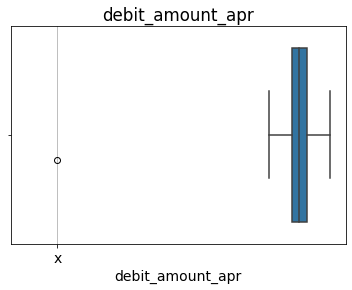

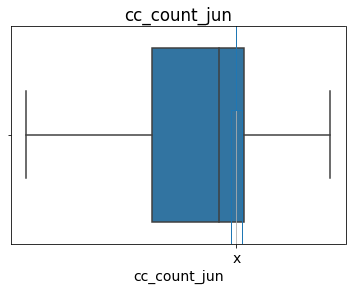

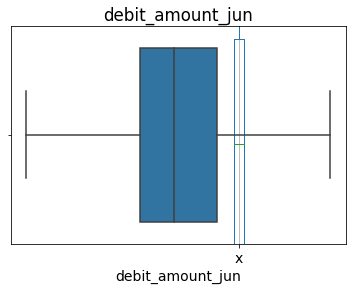

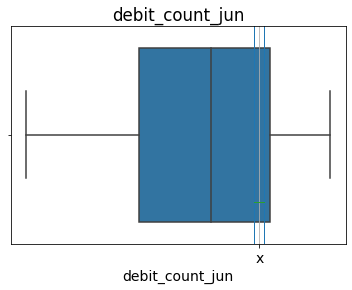

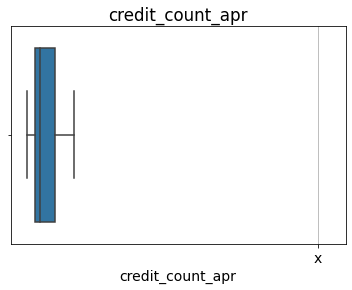

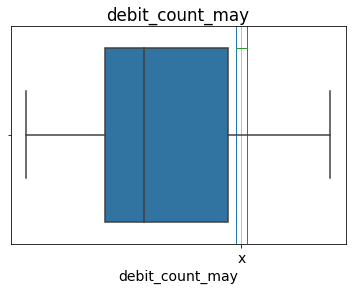

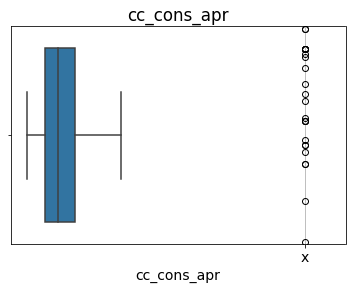

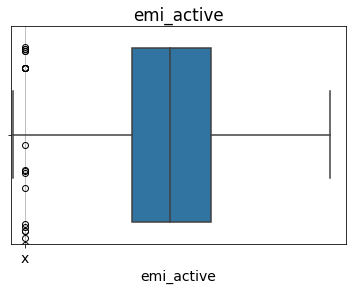

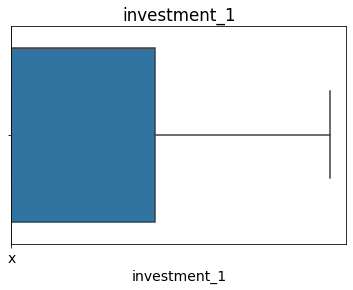

In [139]:
#Outlier treatment - X
for i in numcol_X:
    _, bp = pd.DataFrame.boxplot(real_Xtf[i], return_type='both')
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]
    real_Xtf[i].clip(lower=whiskers[0][1],upper=whiskers[1][1],inplace=True)
    sns.boxplot(real_Xtf[i])
    plt.title(i)
    plt.show()

In [140]:
#Extracting only important features for prediction
real_X_pred = real_Xtf[features]

In [141]:
#Predicting with XGBoost model as it is robust with outliers

real_y = np.exp(xgb_model.predict(real_X_pred))

In [142]:
real_y

array([14459.849, 15032.969, 13643.936, ..., 14537.766, 14028.594,
       14437.459], dtype=float32)

In [143]:
real['cc_cons'] = real_y

In [144]:
cd '/kaggle/working'

/kaggle/working


In [145]:
real.to_excel('NewData_Predicted.xlsx')

### Saving the models

In [ ]:
import pickle
PIK = "Credit_Card_Consumption_Prediciton.pkl"
model = [rf_reg,knn_model,DT_model,xgb_model]
with open(PIK, "wb") as f:
    pickle.dump(model, f)